# Chapter 8 - Scaling Up GNNs with GraphSAGE

GraphSAGE (Graph Sample and Aggregation) is a framework for inductive representation learning on large graphs
>The key technical decisions behind GraphSAGE include:
    >>Inductive Learning: Unlike transductive methods, GraphSAGE can generate embeddings for previously unseen nodes, making it scalable and adaptable
    >>Neighbor Sampling: It uses neighbor sampling to efficiently generate embeddings by sampling and aggregating features from a node's local neighborhood
    >>Aggregation Functions: GraphSAGE employs various aggregation functions (mean, LSTM, pooling) to combine features from neighbors, allowing flexibility in capturing different types of information
    >>Layer-wise Training: The model is trained layer-by-layer, which helps in learning hierarchical representations of nodes

PinSage (Pinterest SAGE) is a Graph Convolutional Network (GCN) designed for web-scale recommender systems
>The key technical decisions behind PinSage include:
    >>Random Walks: PinSage uses random walks to sample relevant subgraphs, which helps in capturing the local structure of the graph
    >>Graph Convolution: It combines efficient random walks with graph convolutions to generate embeddings that incorporate both graph structure and node features
    >>Dynamic Graph Construction: PinSage dynamically constructs graphs based on user interactions, ensuring that the embeddings are up-to-date and relevant
    >>Distributed Computing: To handle web-scale data, PinSage employs distributed computing techniques to scale efficiently and handle billions of items and users

Classifying nodes on PubMed

In [1]:
import torch
torch.manual_seed(-1)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [2]:
#Downloading the dataset and exploring it
from torch_geometric.datasets import Planetoid

dataset = Planetoid(root='.', name="Pubmed")
data = dataset[0]

# Print information about the dataset
print(f'Dataset: {dataset}')
print('-------------------')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of nodes: {data.x.shape[0]}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

# Print information about the graph
print(f'\nGraph:')
print('------')
print(f'Training nodes: {sum(data.train_mask).item()}')
print(f'Evaluation nodes: {sum(data.val_mask).item()}')
print(f'Test nodes: {sum(data.test_mask).item()}')
print(f'Edges are directed: {data.is_directed()}')
print(f'Graph has isolated nodes: {data.has_isolated_nodes()}')
print(f'Graph has loops: {data.has_self_loops()}')

Dataset: Pubmed()
-------------------
Number of graphs: 1
Number of nodes: 19717
Number of features: 500
Number of classes: 3

Graph:
------
Training nodes: 60
Evaluation nodes: 500
Test nodes: 1000
Edges are directed: False
Graph has isolated nodes: False
Graph has loops: False


In [3]:
#Using the NeigborLoader to create neighbor samplings from the dataset with 5 neighbors for the 1-hop and 10 neighbors for the 2-hop along with batch size of 16
from torch_geometric.loader import NeighborLoader
from torch_geometric.utils import to_networkx

# Create batches with neighbor sampling
train_loader = NeighborLoader(
    data,
    num_neighbors=[10, 10],
    batch_size=10,
    input_nodes=data.train_mask,
)

# Print each subgraph
for i, subgraph in enumerate(train_loader):
    print(f'Subgraph {i}: {subgraph}')

Subgraph 0: Data(x=[357, 500], edge_index=[2, 428], y=[357], train_mask=[357], val_mask=[357], test_mask=[357], n_id=[357], e_id=[428], input_id=[10], batch_size=10)
Subgraph 1: Data(x=[264, 500], edge_index=[2, 359], y=[264], train_mask=[264], val_mask=[264], test_mask=[264], n_id=[264], e_id=[359], input_id=[10], batch_size=10)
Subgraph 2: Data(x=[169, 500], edge_index=[2, 181], y=[169], train_mask=[169], val_mask=[169], test_mask=[169], n_id=[169], e_id=[181], input_id=[10], batch_size=10)
Subgraph 3: Data(x=[147, 500], edge_index=[2, 170], y=[147], train_mask=[147], val_mask=[147], test_mask=[147], n_id=[147], e_id=[170], input_id=[10], batch_size=10)
Subgraph 4: Data(x=[329, 500], edge_index=[2, 404], y=[329], train_mask=[329], val_mask=[329], test_mask=[329], n_id=[329], e_id=[404], input_id=[10], batch_size=10)
Subgraph 5: Data(x=[138, 500], edge_index=[2, 168], y=[138], train_mask=[138], val_mask=[138], test_mask=[138], n_id=[138], e_id=[168], input_id=[10], batch_size=10)


In [4]:
x = zip(train_loader, [221, 222, 223, 224])
print(tuple(x))

((Data(x=[356, 500], edge_index=[2, 431], y=[356], train_mask=[356], val_mask=[356], test_mask=[356], n_id=[356], e_id=[431], input_id=[10], batch_size=10), 221), (Data(x=[266, 500], edge_index=[2, 366], y=[266], train_mask=[266], val_mask=[266], test_mask=[266], n_id=[266], e_id=[366], input_id=[10], batch_size=10), 222), (Data(x=[162, 500], edge_index=[2, 181], y=[162], train_mask=[162], val_mask=[162], test_mask=[162], n_id=[162], e_id=[181], input_id=[10], batch_size=10), 223), (Data(x=[158, 500], edge_index=[2, 176], y=[158], train_mask=[158], val_mask=[158], test_mask=[158], n_id=[158], e_id=[176], input_id=[10], batch_size=10), 224))


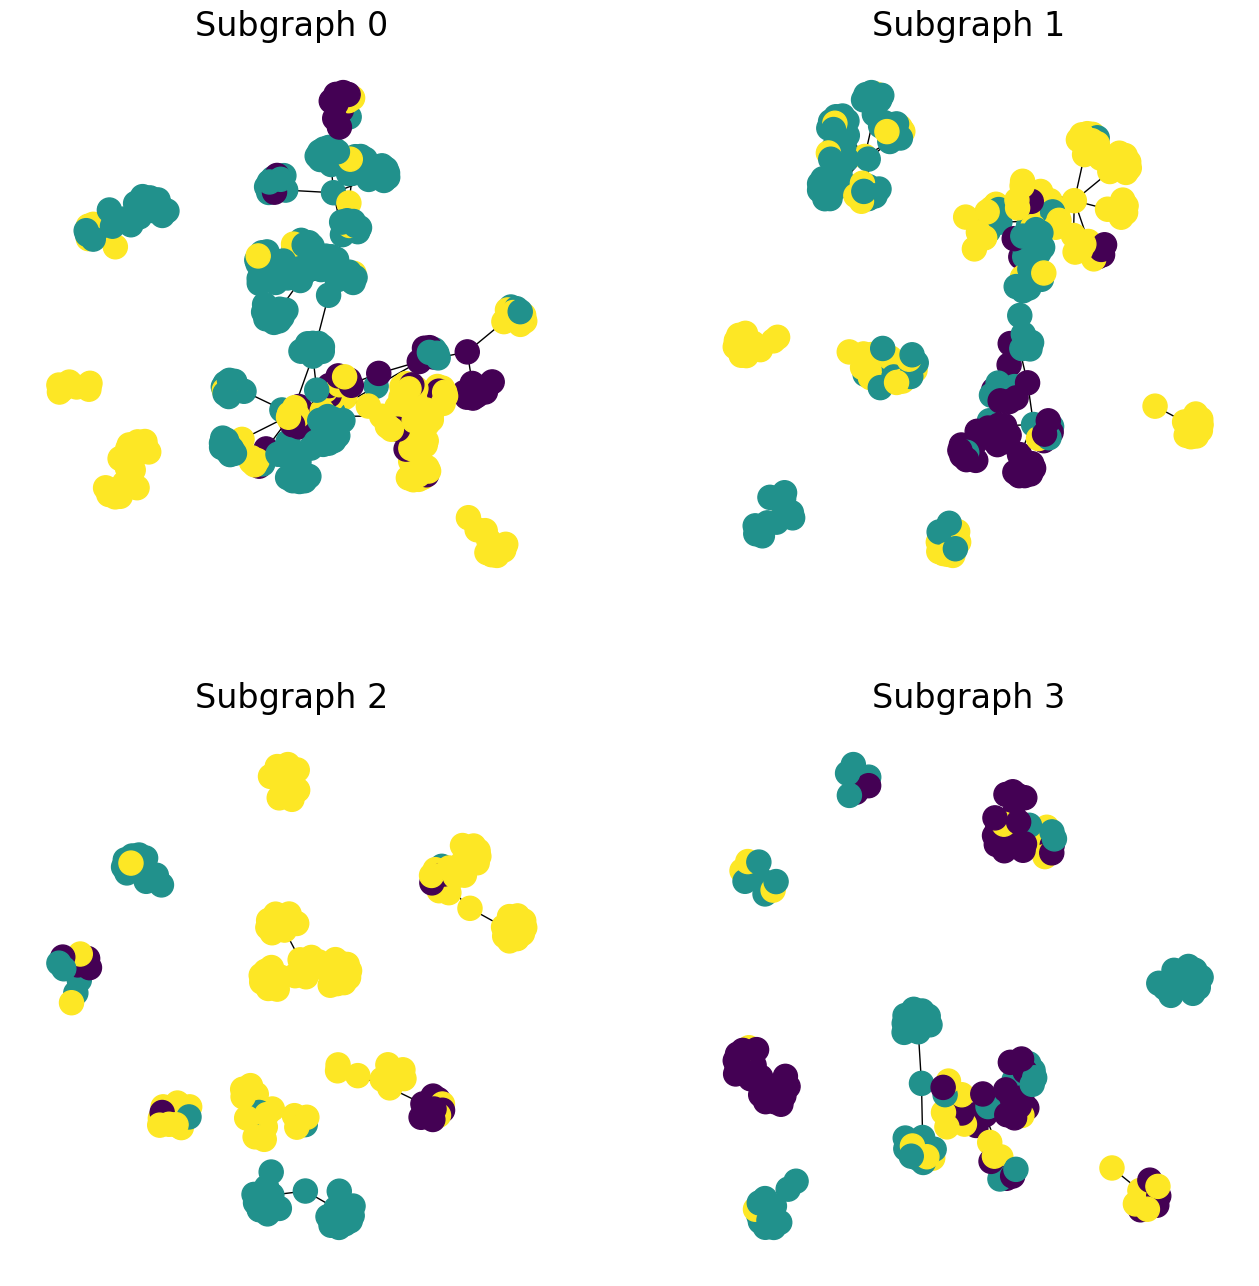

In [5]:
#Plotting the subgraphs
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# Plot each subgraph
fig = plt.figure(figsize=(16,16))
for idx, (subdata, pos) in enumerate(zip(train_loader, [221, 222, 223, 224])):
    G = to_networkx(subdata, to_undirected=True)
    ax = fig.add_subplot(pos)
    ax.set_title(f'Subgraph {idx}', fontsize=24)
    plt.axis('off')
    nx.draw_networkx(G,
                    pos=nx.spring_layout(G, seed=0),
                    with_labels=False,
                    node_color=subdata.y,
                    )
plt.show()

In [6]:
import torch
torch.manual_seed(-1)
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv


def accuracy(pred_y, y):
    """Calculate accuracy."""
    return ((pred_y == y).sum() / len(y)).item()


class GraphSAGE(torch.nn.Module):
    """GraphSAGE"""
    def __init__(self, dim_in, dim_h, dim_out):
        super().__init__()
        self.sage1 = SAGEConv(dim_in, dim_h)
        self.sage2 = SAGEConv(dim_h, dim_out)

    def forward(self, x, edge_index):
        h = self.sage1(x, edge_index)
        h = torch.relu(h)
        h = F.dropout(h, p=0.5, training=self.training)
        h = self.sage2(h, edge_index)
        return h

    def fit(self, loader, epochs):
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=0.01)

        self.train()
        for epoch in range(epochs+1):
            total_loss = 0
            acc = 0
            val_loss = 0
            val_acc = 0

            # Train on batches
            for batch in loader:
                optimizer.zero_grad()
                out = self(batch.x, batch.edge_index)
                loss = criterion(out[batch.train_mask], batch.y[batch.train_mask])
                total_loss += loss.item()
                acc += accuracy(out[batch.train_mask].argmax(dim=1), batch.y[batch.train_mask])
                loss.backward()
                optimizer.step()

                # Validation
                val_loss += criterion(out[batch.val_mask], batch.y[batch.val_mask])
                val_acc += accuracy(out[batch.val_mask].argmax(dim=1), batch.y[batch.val_mask])

            # Print metrics every 10 epochs
            if epoch % 20 == 0:
                print(f'Epoch {epoch:>3} | Train Loss: {loss/len(loader):.3f} | Train Acc: {acc/len(loader)*100:>6.2f}% | Val Loss: {val_loss/len(train_loader):.2f} | Val Acc: {val_acc/len(train_loader)*100:.2f}%')

    @torch.no_grad()
    def test(self, data):
        self.eval()
        out = self(data.x, data.edge_index)
        acc = accuracy(out.argmax(dim=1)[data.test_mask], data.y[data.test_mask])
        return acc

In [7]:
# Create GraphSAGE
graphsage = GraphSAGE(dataset.num_features, 64, dataset.num_classes)
print(graphsage)

# Train
graphsage.fit(train_loader, 200)

# Test
acc = graphsage.test(data)
print(f'GraphSAGE test accuracy: {acc*100:.2f}%')

GraphSAGE(
  (sage1): SAGEConv(500, 64, aggr=mean)
  (sage2): SAGEConv(64, 3, aggr=mean)
)
Epoch   0 | Train Loss: 0.221 | Train Acc:  31.97% | Val Loss: 1.12 | Val Acc: 29.86%
Epoch  20 | Train Loss: 0.001 | Train Acc: 100.00% | Val Loss: 0.61 | Val Acc: 69.07%
Epoch  40 | Train Loss: 0.000 | Train Acc: 100.00% | Val Loss: 0.60 | Val Acc: 78.15%
Epoch  60 | Train Loss: 0.000 | Train Acc: 100.00% | Val Loss: 0.40 | Val Acc: 83.98%
Epoch  80 | Train Loss: 0.000 | Train Acc: 100.00% | Val Loss: 0.82 | Val Acc: 66.75%
Epoch 100 | Train Loss: 0.000 | Train Acc: 100.00% | Val Loss: 0.75 | Val Acc: 72.22%
Epoch 120 | Train Loss: 0.000 | Train Acc: 100.00% | Val Loss: 0.70 | Val Acc: 74.52%
Epoch 140 | Train Loss: 0.000 | Train Acc: 100.00% | Val Loss: 0.60 | Val Acc: 73.56%
Epoch 160 | Train Loss: 0.000 | Train Acc: 100.00% | Val Loss: 0.87 | Val Acc: 69.86%
Epoch 180 | Train Loss: 0.000 | Train Acc: 100.00% | Val Loss: 0.89 | Val Acc: 76.39%
Epoch 200 | Train Loss: 0.000 | Train Acc: 100.00

The example above is transducive learning because we mask the test dataset during training

Inductive learning on protein-protein interactions

In [8]:
import torch
from sklearn.metrics import f1_score

from torch_geometric.datasets import PPI
from torch_geometric.data import Batch
from torch_geometric.loader import DataLoader, NeighborLoader
from torch_geometric.nn import GraphSAGE

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(torch.device('cpu'))

# Load training, evaluation, and test sets
train_dataset = PPI(root=".", split='train')
val_dataset = PPI(root=".", split='val')
test_dataset = PPI(root=".", split='test')

# Unify the training graphs and apply neighbor sampling
train_data = Batch.from_data_list(train_dataset)
train_loader = NeighborLoader(train_data, batch_size=2048, shuffle=True, num_neighbors=[20, 10], num_workers=2, persistent_workers=True)

# Evaluation loaders (one datapoint corresponds to a graph)
val_loader = DataLoader(val_dataset, batch_size=2)
test_loader = DataLoader(test_dataset, batch_size=2)

cpu


In [9]:
#Creating the GraphSAGE model
model = GraphSAGE(
    in_channels=train_dataset.num_features,
    hidden_channels=512,
    num_layers=2,
    out_channels=train_dataset.num_classes,
).to(device)

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

def fit(loader):
    model.train()
    total_loss = 0
    for data in loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index)
        loss = criterion(out, data.y)
        total_loss += loss.item() * data.num_graphs
        loss.backward()
        optimizer.step()
    return total_loss / len(loader.data)

@torch.no_grad()
def test(loader):
    model.eval()

    data = next(iter(loader))
    out = model(data.x.to(device), data.edge_index.to(device))
    preds = (out > 0).float().cpu()

    y, pred = data.y.numpy(), preds.numpy()
    return f1_score(y, pred, average='micro') if pred.sum() > 0 else 0

for epoch in range(301):
    loss = fit(train_loader)
    val_f1 = test(val_loader)
    if epoch % 50 == 0:
        print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | Val F1-score: {val_f1:.4f}')

print(f'Test F1-score: {test(test_loader):.4f}')

Epoch   0 | Train Loss: 12.697 | Val F1-score: 0.4846
Epoch  50 | Train Loss: 8.743 | Val F1-score: 0.7953
Epoch 100 | Train Loss: 8.602 | Val F1-score: 0.8123
Epoch 150 | Train Loss: 8.560 | Val F1-score: 0.8192
Epoch 200 | Train Loss: 8.501 | Val F1-score: 0.8228
Epoch 250 | Train Loss: 8.465 | Val F1-score: 0.8252
Epoch 300 | Train Loss: 8.458 | Val F1-score: 0.8274
Test F1-score: 0.8518


# Chapter 9 - Defining Expressiveness for Graph Classification

Using GIN (Graph Isomorphism Network) to classify a protein dataset

In [10]:
torch.manual_seed(11)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [11]:
#Looking at few important pieces of information about the dataset
from torch_geometric.datasets import TUDataset

dataset = TUDataset(root='.', name='PROTEINS').shuffle()

# Print information about the dataset
print(f'Dataset: {dataset}')
print('-----------------------')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of nodes: {dataset[0].x.shape[0]}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

Processing...


Dataset: PROTEINS(1113)
-----------------------
Number of graphs: 1113
Number of nodes: 14
Number of features: 3
Number of classes: 2


Done!


In [12]:
#Splitting the dataset
from torch_geometric.loader import DataLoader

# Create training, validation, and test sets
train_dataset = dataset[:int(len(dataset)*0.8)]
val_dataset   = dataset[int(len(dataset)*0.8):int(len(dataset)*0.9)]
test_dataset  = dataset[int(len(dataset)*0.9):]

print(f'Training set   = {len(train_dataset)} graphs')
print(f'Validation set = {len(val_dataset)} graphs')
print(f'Test set       = {len(test_dataset)} graphs')

# Create mini-batches
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=True)

print('\nTrain loader:')
for i, batch in enumerate(train_loader):
    print(f' - Batch {i}: {batch}')

print('\nValidation loader:')
for i, batch in enumerate(val_loader):
    print(f' - Batch {i}: {batch}')

print('\nTest loader:')
for i, batch in enumerate(test_loader):
    print(f' - Batch {i}: {batch}')

Training set   = 890 graphs
Validation set = 111 graphs
Test set       = 112 graphs

Train loader:
 - Batch 0: DataBatch(edge_index=[2, 9274], x=[2468, 3], y=[64], batch=[2468], ptr=[65])
 - Batch 1: DataBatch(edge_index=[2, 8972], x=[2366, 3], y=[64], batch=[2366], ptr=[65])
 - Batch 2: DataBatch(edge_index=[2, 8820], x=[2350, 3], y=[64], batch=[2350], ptr=[65])
 - Batch 3: DataBatch(edge_index=[2, 9596], x=[2570, 3], y=[64], batch=[2570], ptr=[65])
 - Batch 4: DataBatch(edge_index=[2, 9108], x=[2490, 3], y=[64], batch=[2490], ptr=[65])
 - Batch 5: DataBatch(edge_index=[2, 10022], x=[2637, 3], y=[64], batch=[2637], ptr=[65])
 - Batch 6: DataBatch(edge_index=[2, 9732], x=[2726, 3], y=[64], batch=[2726], ptr=[65])
 - Batch 7: DataBatch(edge_index=[2, 9316], x=[2533, 3], y=[64], batch=[2533], ptr=[65])
 - Batch 8: DataBatch(edge_index=[2, 7994], x=[2074, 3], y=[64], batch=[2074], ptr=[65])
 - Batch 9: DataBatch(edge_index=[2, 11984], x=[3267, 3], y=[64], batch=[3267], ptr=[65])
 - Batch 

In [13]:
#Creating the GCN for comparison
import torch
torch.manual_seed(0)
import torch.nn.functional as F
from torch.nn import Linear, Sequential, BatchNorm1d, ReLU, Dropout
from torch_geometric.nn import GCNConv, GINConv
from torch_geometric.nn import global_mean_pool, global_add_pool


class GCN(torch.nn.Module):
    """GCN"""
    def __init__(self, dim_h):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(dataset.num_node_features, dim_h)
        self.conv2 = GCNConv(dim_h, dim_h)
        self.conv3 = GCNConv(dim_h, dim_h)
        self.lin = Linear(dim_h, dataset.num_classes)

    def forward(self, x, edge_index, batch):
        # Node embeddings 
        h = self.conv1(x, edge_index)
        h = h.relu()
        h = self.conv2(h, edge_index)
        h = h.relu()
        h = self.conv3(h, edge_index)

        # Graph-level readout
        hG = global_mean_pool(h, batch)

        # Classifier
        h = F.dropout(hG, p=0.5, training=self.training)
        h = self.lin(h)
        
        return F.log_softmax(h, dim=1)

In [14]:
#Creating the GIN
class GIN(torch.nn.Module):
    """GIN"""
    def __init__(self, dim_h):
        super(GIN, self).__init__()
        self.conv1 = GINConv(
            Sequential(Linear(dataset.num_node_features, dim_h),
                       BatchNorm1d(dim_h), ReLU(),
                       Linear(dim_h, dim_h), ReLU()))
        self.conv2 = GINConv(
            Sequential(Linear(dim_h, dim_h), BatchNorm1d(dim_h), ReLU(),
                       Linear(dim_h, dim_h), ReLU()))
        self.conv3 = GINConv(
            Sequential(Linear(dim_h, dim_h), BatchNorm1d(dim_h), ReLU(),
                       Linear(dim_h, dim_h), ReLU()))
        self.lin1 = Linear(dim_h*3, dim_h*3)
        self.lin2 = Linear(dim_h*3, dataset.num_classes)

    def forward(self, x, edge_index, batch):
        # Node embeddings 
        h1 = self.conv1(x, edge_index)
        h2 = self.conv2(h1, edge_index)
        h3 = self.conv3(h2, edge_index)

        # Graph-level readout
        h1 = global_add_pool(h1, batch)
        h2 = global_add_pool(h2, batch)
        h3 = global_add_pool(h3, batch)

        # Concatenate graph embeddings
        h = torch.cat((h1, h2, h3), dim=1)

        # Classifier
        h = self.lin1(h)
        h = h.relu()
        h = F.dropout(h, p=0.5, training=self.training)
        h = self.lin2(h)
        
        return F.log_softmax(h, dim=1)

In [15]:
#Creating the training and testing functions
def train(model, loader):
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    epochs = 100

    model.train()
    for epoch in range(epochs+1):
        total_loss = 0
        acc = 0
        val_loss = 0
        val_acc = 0

        # Train on batches
        for data in loader:
            optimizer.zero_grad()
            out = model(data.x, data.edge_index, data.batch)
            loss = criterion(out, data.y)
            total_loss += loss / len(loader)
            acc += accuracy(out.argmax(dim=1), data.y) / len(loader)
            loss.backward()
            optimizer.step()

            # Validation
            val_loss, val_acc = test(model, val_loader)

        # Print metrics every 20 epochs
        if(epoch % 20 == 0):
            print(f'Epoch {epoch:>3} | Train Loss: {total_loss:.2f} | Train Acc: {acc*100:>5.2f}% | Val Loss: {val_loss:.2f} | Val Acc: {val_acc*100:.2f}%')
            
    return model

@torch.no_grad()
def test(model, loader):
    criterion = torch.nn.CrossEntropyLoss()
    model.eval()
    loss = 0
    acc = 0

    for data in loader:
        out = model(data.x, data.edge_index, data.batch)
        loss += criterion(out, data.y) / len(loader)
        acc += accuracy(out.argmax(dim=1), data.y) / len(loader)

    return loss, acc

def accuracy(pred_y, y):
    """Calculate accuracy."""
    return ((pred_y == y).sum() / len(y)).item()

In [16]:
#Training, testing and quanitfying the model
gcn = GCN(dim_h=32)
gcn = train(gcn, train_loader)
test_loss, test_acc = test(gcn, test_loader)
print(f'Test Loss: {test_loss:.2f} | Test Acc: {test_acc*100:.2f}%')
print()

gin = GIN(dim_h=32)
gin = train(gin, train_loader)
test_loss, test_acc = test(gin, test_loader)
print(f'Test Loss: {test_loss:.2f} | Test Acc: {test_acc*100:.2f}%')

Epoch   0 | Train Loss: 0.68 | Train Acc: 58.59% | Val Loss: 0.67 | Val Acc: 62.17%
Epoch  20 | Train Loss: 0.60 | Train Acc: 70.87% | Val Loss: 0.58 | Val Acc: 70.55%
Epoch  40 | Train Loss: 0.60 | Train Acc: 70.45% | Val Loss: 0.58 | Val Acc: 73.74%
Epoch  60 | Train Loss: 0.59 | Train Acc: 71.30% | Val Loss: 0.57 | Val Acc: 72.74%
Epoch  80 | Train Loss: 0.59 | Train Acc: 70.84% | Val Loss: 0.58 | Val Acc: 73.39%
Epoch 100 | Train Loss: 0.59 | Train Acc: 72.33% | Val Loss: 0.58 | Val Acc: 73.89%
Test Loss: 0.62 | Test Acc: 71.09%

Epoch   0 | Train Loss: 1.59 | Train Acc: 59.13% | Val Loss: 0.63 | Val Acc: 68.63%
Epoch  20 | Train Loss: 0.53 | Train Acc: 75.71% | Val Loss: 0.51 | Val Acc: 81.83%
Epoch  40 | Train Loss: 0.53 | Train Acc: 74.21% | Val Loss: 0.53 | Val Acc: 80.83%
Epoch  60 | Train Loss: 0.49 | Train Acc: 76.14% | Val Loss: 0.48 | Val Acc: 75.23%
Epoch  80 | Train Loss: 0.48 | Train Acc: 76.87% | Val Loss: 0.52 | Val Acc: 78.71%
Epoch 100 | Train Loss: 0.48 | Train Acc

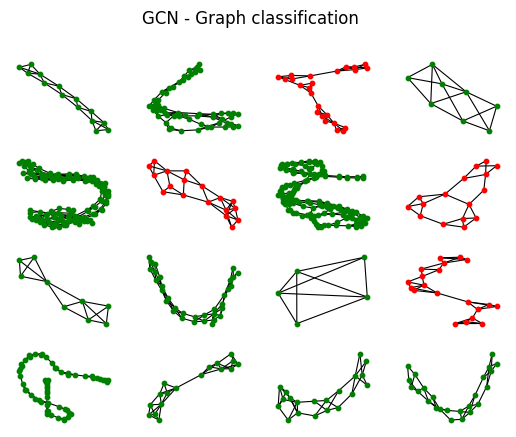

In [17]:
#Visualizing the correctly and incorrectly classified protein structures
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from torch_geometric.utils import to_networkx

fig, ax = plt.subplots(4, 4)
fig.suptitle('GCN - Graph classification')

for i, data in enumerate(dataset[-16:]):
    # Calculate color (green if correct, red otherwise)
    out = gcn(data.x, data.edge_index, data.batch)
    color = "green" if out.argmax(dim=1) == data.y else "red"

    # Plot graph
    ix = np.unravel_index(i, ax.shape)
    ax[ix].axis('off')
    G = to_networkx(dataset[i], to_undirected=True)
    nx.draw_networkx(G,
                    pos=nx.spring_layout(G, seed=0),
                    with_labels=False,
                    node_size=10,
                    node_color=color,
                    width=0.8,
                    ax=ax[ix]
                    )

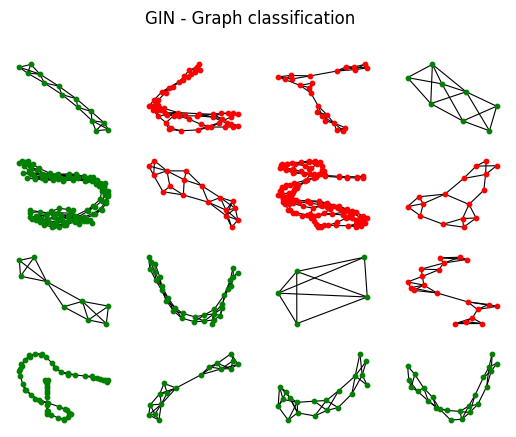

In [18]:
fig, ax = plt.subplots(4, 4)
fig.suptitle('GIN - Graph classification')

for i, data in enumerate(dataset[-16:]):
    # Calculate color (green if correct, red otherwise)
    out = gin(data.x, data.edge_index, data.batch)
    color = "green" if out.argmax(dim=1) == data.y else "red"

    # Plot graph
    ix = np.unravel_index(i, ax.shape)
    ax[ix].axis('off')
    G = to_networkx(dataset[i], to_undirected=True)
    nx.draw_networkx(G,
                    pos=nx.spring_layout(G, seed=0),
                    with_labels=False,
                    node_size=10,
                    node_color=color,
                    width=0.8,
                    ax=ax[ix]
                    )

In [19]:
#Evaluating models and looking into the possibility of an ensemble model
gcn.eval()
gin.eval()
acc_gcn = 0
acc_gin = 0
acc_ens = 0

for data in test_loader:
    # Get classifications
    out_gcn = gcn(data.x, data.edge_index, data.batch)
    out_gin = gin(data.x, data.edge_index, data.batch)
    out_ens = (out_gcn + out_gin)/2

    # Calculate accuracy scores
    acc_gcn += accuracy(out_gcn.argmax(dim=1), data.y) / len(test_loader)
    acc_gin += accuracy(out_gin.argmax(dim=1), data.y) / len(test_loader)
    acc_ens += accuracy(out_ens.argmax(dim=1), data.y) / len(test_loader)

# Print results
print(f'GCN accuracy:     {acc_gcn*100:.2f}%')
print(f'GIN accuracy:     {acc_gin*100:.2f}%')
print(f'GCN+GIN accuracy: {acc_ens*100:.2f}%')

GCN accuracy:     71.88%
GIN accuracy:     71.35%
GCN+GIN accuracy: 71.88%


# Chapter 10 - Predicting Links with Graph Neural Networks

Predicting links with node embeddings using VGAE (Variable Graph AutoEncoders)

In [20]:
import torch
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [21]:
# Normalize the dataset for use with GAE and VGAE
import numpy as np
np.random.seed(0)
import torch
torch.manual_seed(0)
import matplotlib.pyplot as plt
import torch_geometric.transforms as T
from torch_geometric.datasets import Planetoid

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

transform = T.Compose([
    T.NormalizeFeatures(),
    T.ToDevice(device),
    T.RandomLinkSplit(num_val=0.05, num_test=0.1, is_undirected=True, split_labels=True, add_negative_train_samples=False),
])

dataset = Planetoid('.', name='Cora', transform=transform)

train_data, val_data, test_data = dataset[0]

Processing...
Done!


In [22]:
# Creating the encoding class
from torch_geometric.nn import GCNConv, VGAE

class Encoder(torch.nn.Module):
    def __init__(self, dim_in, dim_out):
        super().__init__()
        self.conv1 = GCNConv(dim_in, 2 * dim_out)
        self.conv_mu = GCNConv(2 * dim_out, dim_out)
        self.conv_logstd = GCNConv(2 * dim_out, dim_out)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv_mu(x, edge_index), self.conv_logstd(x, edge_index)

In [23]:
# Defining training and testing functions
model = VGAE(Encoder(dataset.num_features, 16)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

def train():
    model.train()
    optimizer.zero_grad()
    z = model.encode(train_data.x, train_data.edge_index)
    loss = model.recon_loss(z, train_data.pos_edge_label_index) + (1 / train_data.num_nodes) * model.kl_loss()
    loss.backward()
    optimizer.step()
    return float(loss)

@torch.no_grad()
def test(data):
    model.eval()
    z = model.encode(data.x, data.edge_index)
    return model.test(z, data.pos_edge_label_index, data.neg_edge_label_index)

In [24]:
# Training on dataset
for epoch in range(301):
    loss = train()
    val_auc, val_ap = test(test_data)
    if epoch % 50 == 0:
        print(f'Epoch {epoch:>2} | Loss: {loss:.4f} | Val AUC: {val_auc:.4f} | Val AP: {val_ap:.4f}') 

test_auc, test_ap = test(test_data) 
print(f'Test AUC: {test_auc:.4f} | Test AP {test_ap:.4f}')

Epoch  0 | Loss: 3.4861 | Val AUC: 0.6792 | Val AP: 0.7070
Epoch 50 | Loss: 1.3293 | Val AUC: 0.6838 | Val AP: 0.7016
Epoch 100 | Loss: 1.1734 | Val AUC: 0.7229 | Val AP: 0.7301
Epoch 150 | Loss: 1.0760 | Val AUC: 0.7777 | Val AP: 0.7775
Epoch 200 | Loss: 1.0249 | Val AUC: 0.8293 | Val AP: 0.8282
Epoch 250 | Loss: 1.0081 | Val AUC: 0.8328 | Val AP: 0.8291
Epoch 300 | Loss: 0.9789 | Val AUC: 0.8379 | Val AP: 0.8366
Test AUC: 0.8379 | Test AP 0.8366


In [26]:
# Calculating the approximated adjacency matrix
z = model.encode(test_data.x, test_data.edge_index) 
Ahat = torch.sigmoid(z @ z.T)
Ahat

tensor([[0.7128, 0.6939, 0.7573,  ..., 0.4947, 0.7285, 0.7677],
        [0.6939, 0.7306, 0.7915,  ..., 0.5364, 0.7620, 0.7755],
        [0.7573, 0.7915, 0.8719,  ..., 0.5410, 0.8479, 0.8568],
        ...,
        [0.4947, 0.5364, 0.5410,  ..., 0.5714, 0.5441, 0.5188],
        [0.7285, 0.7620, 0.8479,  ..., 0.5441, 0.8268, 0.8312],
        [0.7677, 0.7755, 0.8568,  ..., 0.5188, 0.8312, 0.8523]],
       grad_fn=<SigmoidBackward0>)

Predicting links with SEAL

In [27]:
import numpy as np
from sklearn.metrics import roc_auc_score, average_precision_score
from scipy.sparse.csgraph import shortest_path

import torch.nn.functional as F
from torch.nn import Conv1d, MaxPool1d, Linear, Dropout, BCEWithLogitsLoss

from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import RandomLinkSplit
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, aggr
from torch_geometric.utils import k_hop_subgraph, to_scipy_sparse_matrix

In [28]:
# Load Cora dataset
transform = RandomLinkSplit(num_val=0.05, num_test=0.1, is_undirected=True, split_labels=True)
dataset = Planetoid('.', name='Cora', transform=transform)
train_data, val_data, test_data = dataset[0]
train_data

Data(x=[2708, 1433], edge_index=[2, 8976], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708], pos_edge_label=[4488], pos_edge_label_index=[2, 4488], neg_edge_label=[4488], neg_edge_label_index=[2, 4488])

In [29]:
# Processing dataset for SEAL
def seal_processing(dataset, edge_label_index, y):
    #List that we are going to retun which is our dataset
    data_list = []
    #Looping through each source and destination node
    for src, dst in edge_label_index.t().tolist():
        # Extract the k-hop neighbourhoods
        sub_nodes, sub_edge_index, mapping, _ = k_hop_subgraph([src, dst], 2, dataset.edge_index, relabel_nodes=True)
        src, dst = mapping.tolist()

        # Remove target link from the subgraph
        mask1 = (sub_edge_index[0] != src) | (sub_edge_index[1] != dst)
        mask2 = (sub_edge_index[0] != dst) | (sub_edge_index[1] != src)
        sub_edge_index = sub_edge_index[:, mask1 & mask2]

        # Double-radius node labeling (DRNL)
        src, dst = (dst, src) if src > dst else (src, dst)
        adj = to_scipy_sparse_matrix(sub_edge_index, num_nodes=sub_nodes.size(0)).tocsr()

        idx = list(range(src)) + list(range(src + 1, adj.shape[0]))
        adj_wo_src = adj[idx, :][:, idx]

        idx = list(range(dst)) + list(range(dst + 1, adj.shape[0]))
        adj_wo_dst = adj[idx, :][:, idx]

        # Calculate the distance between every node and the source target node
        d_src = shortest_path(adj_wo_dst, directed=False, unweighted=True, indices=src)
        d_src = np.insert(d_src, dst, 0, axis=0)
        d_src = torch.from_numpy(d_src)

        # Calculate the distance between every node and the destination target node
        d_dst = shortest_path(adj_wo_src, directed=False, unweighted=True, indices=dst-1)
        d_dst = np.insert(d_dst, src, 0, axis=0)
        d_dst = torch.from_numpy(d_dst)

        # Calculate the label z for each node
        dist = d_src + d_dst
        z = 1 + torch.min(d_src, d_dst) + dist // 2 * (dist // 2 + dist % 2 - 1)
        z[src], z[dst], z[torch.isnan(z)] = 1., 1., 0.
        z = z.to(torch.long)

        # Concatenate node features and one-hot encoded node labels (with a fixed number of classes)
        node_labels = F.one_hot(z, num_classes=200).to(torch.float)
        node_emb = dataset.x[sub_nodes]
        node_x = torch.cat([node_emb, node_labels], dim=1)

        # Create data object
        data = Data(x=node_x, z=z, edge_index=sub_edge_index, y=y)
        data_list.append(data)

    return data_list

In [30]:
# Enclosing subgraphs extraction
train_pos_data_list = seal_processing(train_data, train_data.pos_edge_label_index, 1)
train_neg_data_list = seal_processing(train_data, train_data.neg_edge_label_index, 0)

val_pos_data_list = seal_processing(val_data, val_data.pos_edge_label_index, 1)
val_neg_data_list = seal_processing(val_data, val_data.neg_edge_label_index, 0)

test_pos_data_list = seal_processing(test_data, test_data.pos_edge_label_index, 1)
test_neg_data_list = seal_processing(test_data, test_data.neg_edge_label_index, 0)

In [31]:
train_dataset = train_pos_data_list + train_neg_data_list
val_dataset = val_pos_data_list + val_neg_data_list
test_dataset = test_pos_data_list + test_neg_data_list

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

In [32]:
class DGCNN(torch.nn.Module):
    def __init__(self, dim_in, k=30):
        super().__init__()

        # GCN layers
        self.gcn1 = GCNConv(dim_in, 32)
        self.gcn2 = GCNConv(32, 32)
        self.gcn3 = GCNConv(32, 32)
        self.gcn4 = GCNConv(32, 1)

        # Global sort pooling
        self.global_pool = aggr.SortAggregation(k=k)

        # Convolutional layers
        self.conv1 = Conv1d(1, 16, 97, 97)
        self.conv2 = Conv1d(16, 32, 5, 1)
        self.maxpool = MaxPool1d(2, 2)

        # Dense layers
        self.linear1 = Linear(352, 128)
        self.dropout = Dropout(0.5)
        self.linear2 = Linear(128, 1)

    def forward(self, x, edge_index, batch):
        # 1. Graph Convolutional Layers
        h1 = self.gcn1(x, edge_index).tanh()
        h2 = self.gcn2(h1, edge_index).tanh()
        h3 = self.gcn3(h2, edge_index).tanh()
        h4 = self.gcn4(h3, edge_index).tanh()
        h = torch.cat([h1, h2, h3, h4], dim=-1)

        # 2. Global sort pooling
        h = self.global_pool(h, batch)

        # 3. Traditional convolutional and dense layers
        h = h.view(h.size(0), 1, h.size(-1))
        h = self.conv1(h).relu()
        h = self.maxpool(h)
        h = self.conv2(h).relu()
        h = h.view(h.size(0), -1)
        h = self.linear1(h).relu()
        h = self.dropout(h)
        h = self.linear2(h).sigmoid()

        return h

In [33]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = DGCNN(train_dataset[0].num_features).to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.0001)
criterion = BCEWithLogitsLoss()

def train():
    model.train()
    total_loss = 0

    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.batch)
        loss = criterion(out.view(-1), data.y.to(torch.float))
        loss.backward()
        optimizer.step()
        total_loss += float(loss) * data.num_graphs

    return total_loss / len(train_dataset)

@torch.no_grad()
def test(loader):
    model.eval()
    y_pred, y_true = [], []

    for data in loader:
        data = data.to(device)
        out = model(data.x, data.edge_index, data.batch)
        y_pred.append(out.view(-1).cpu())
        y_true.append(data.y.view(-1).cpu().to(torch.float))

    auc = roc_auc_score(torch.cat(y_true), torch.cat(y_pred))
    ap = average_precision_score(torch.cat(y_true), torch.cat(y_pred))

    return auc, ap

for epoch in range(31):
    loss = train()
    val_auc, val_ap = test(val_loader)
    print(f'Epoch {epoch:>2} | Loss: {loss:.4f} | Val AUC: {val_auc:.4f} | Val AP: {val_ap:.4f}')

test_auc, test_ap = test(test_loader)
print(f'Test AUC: {test_auc:.4f} | Test AP {test_ap:.4f}')

Epoch  0 | Loss: 0.7023 | Val AUC: 0.7566 | Val AP: 0.8008
Epoch  1 | Loss: 0.6349 | Val AUC: 0.8151 | Val AP: 0.8555
Epoch  2 | Loss: 0.6100 | Val AUC: 0.8156 | Val AP: 0.8599
Epoch  3 | Loss: 0.6047 | Val AUC: 0.8226 | Val AP: 0.8669
Epoch  4 | Loss: 0.6017 | Val AUC: 0.8266 | Val AP: 0.8729
Epoch  5 | Loss: 0.5991 | Val AUC: 0.8250 | Val AP: 0.8778
Epoch  6 | Loss: 0.5964 | Val AUC: 0.8284 | Val AP: 0.8778
Epoch  7 | Loss: 0.5946 | Val AUC: 0.8298 | Val AP: 0.8772
Epoch  8 | Loss: 0.5931 | Val AUC: 0.8311 | Val AP: 0.8753
Epoch  9 | Loss: 0.5914 | Val AUC: 0.8320 | Val AP: 0.8698
Epoch 10 | Loss: 0.5896 | Val AUC: 0.8331 | Val AP: 0.8670
Epoch 11 | Loss: 0.5886 | Val AUC: 0.8253 | Val AP: 0.8660
Epoch 12 | Loss: 0.5880 | Val AUC: 0.8313 | Val AP: 0.8647
Epoch 13 | Loss: 0.5867 | Val AUC: 0.8337 | Val AP: 0.8649
Epoch 14 | Loss: 0.5851 | Val AUC: 0.8396 | Val AP: 0.8780
Epoch 15 | Loss: 0.5845 | Val AUC: 0.8503 | Val AP: 0.8843
Epoch 16 | Loss: 0.5828 | Val AUC: 0.8502 | Val AP: 0.88

# Chapter 11 - Generating Graphs Using Graph Neural Networks

Generating graphs with traditional techniques

The Erdős–Rényi model

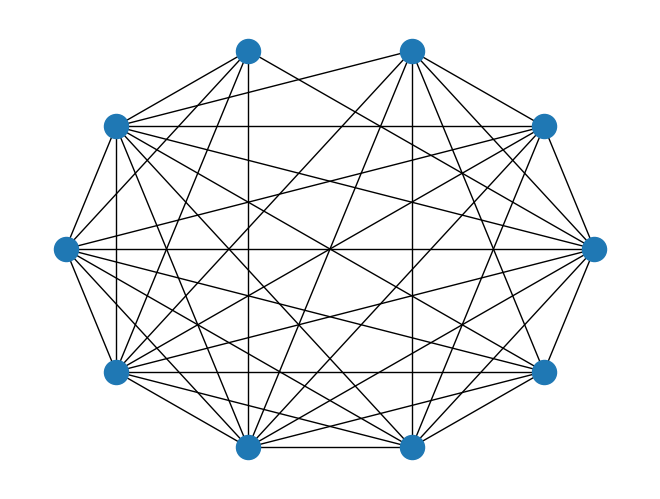

In [34]:
# Using the inbuilt function in networkx to create the Erdos-Renyi graph with a link probability of 0.9 (90% chance of two nodes being connected). This creates a highly connected graph. This uses the G(n, p) model 
import networkx as nx
import matplotlib.pyplot as plt

G = nx.erdos_renyi_graph(10, 0.9, seed=0)
pos = nx.circular_layout(G) 
nx.draw(G, pos=pos)

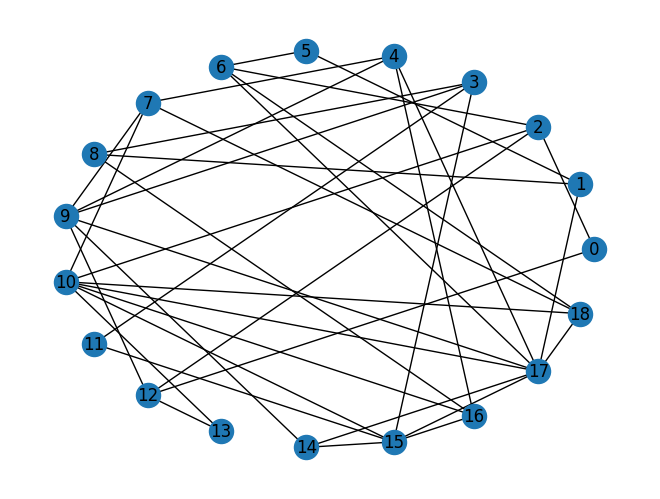

In [42]:
# Using the G(n, m) model
# This is not as easy to analyze as the G(n, p) model. It chooses a random model from all possible graphs of n nodes and M links
G = nx.gnm_random_graph(19, 38, seed=0)
pos = nx.circular_layout(G)
nx.draw(G, pos=pos, with_labels=True)

The small-world model

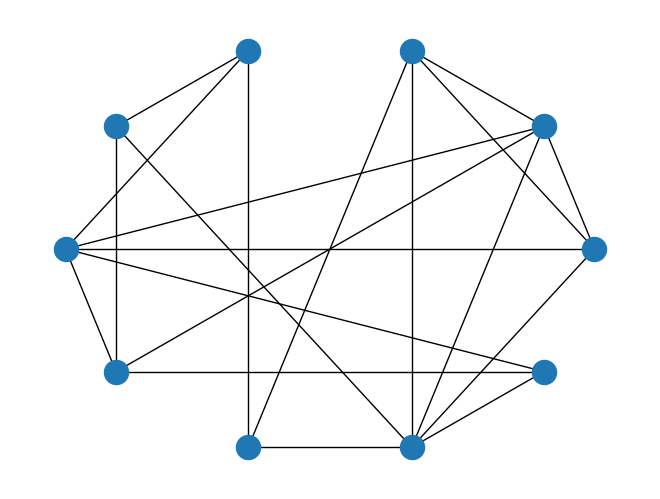

In [43]:
# This type of model is better for technological, social and biological networks
# n = 10 nodes with each node being connected to 4 of it's neighbors (would'be been k - 1 if k was odd) with a 50% probability of the connection i, j being rerouted through k (random node)
G = nx.watts_strogatz_graph(10, 4, 0.5, seed=0)
pos = nx.circular_layout(G)
nx.draw(G, pos=pos)

# Chapter 12 - Learning from Heterogeneous Graphs

Creating a MPNN (Message Passing Neural Network) framework using torch_geometric

In [9]:
import torch
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [10]:
import numpy as np
np.random.seed(0)

import torch
torch.manual_seed(0)
from torch.nn import Linear
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree

In [11]:
#Creating the MPNN
class GCNConv(MessagePassing):
    def __init__(self, dim_in, dim_h):
        #Using the add aggregration
        super().__init__(aggr='add')
        self.linear = Linear(dim_in, dim_h, bias=False)

    def forward(self, x, edge_index):
        # Adding self loops to the adjacency matrix to consider target nodes
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))

        x = self.linear(x)
        # Calculating the normalization function which is the multiplication of the inverse of the square root of degrees of nodes i and j
        row, col = edge_index
        deg = degree(col, x.size(0), dtype=x.dtype)
        deg_inv_sqrt = deg.pow(-0.5)
        deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]

        out = self.propagate(edge_index, x=x, norm=norm)

        return out

    def message(self, x, norm):
        return norm.view(-1, 1) * x

In [12]:
conv = GCNConv(16, 32)

Creating a heterogenous graph dataset

In [13]:
from torch_geometric.data import HeteroData

data = HeteroData()

data['user'].x = torch.Tensor([[1, 1, 1, 1], [2, 2, 2, 2], [3, 3, 3, 3]]) # [num_users, num_features_users]
data['game'].x = torch.Tensor([[1, 1], [2, 2]])
data['dev'].x = torch.Tensor([[1], [2]])

data['user', 'follows', 'user'].edge_index = torch.Tensor([[0, 1], [1, 2]]) # [2, num_edges_follows]
data['user', 'plays', 'game'].edge_index = torch.Tensor([[0, 1, 1, 2], [0, 0, 1, 1]])
data['dev', 'develops', 'game'].edge_index = torch.Tensor([[0, 1], [0, 1]])

data['user', 'plays', 'game'].edge_attr = torch.Tensor([[2], [0.5], [10], [12]])

data

HeteroData(
  user={ x=[3, 4] },
  game={ x=[2, 2] },
  dev={ x=[2, 1] },
  (user, follows, user)={ edge_index=[2, 2] },
  (user, plays, game)={
    edge_index=[2, 4],
    edge_attr=[4, 1],
  },
  (dev, develops, game)={ edge_index=[2, 2] }
)

Transforming homogeneous GNNs to heterogeneous GNNs

In [14]:
from torch import nn
import torch.nn.functional as F

import torch_geometric.transforms as T
from torch_geometric.datasets import DBLP
from torch_geometric.nn import GAT

# Adding a meta-path for author-paper-author. Dropping original edge types since a GAT can only consider one

metapaths = [[('author', 'paper'), ('paper', 'author')]]
transform = T.AddMetaPaths(metapaths=metapaths, drop_orig_edge_types=True)

In [15]:
# Loading and transforming the dataset
dataset = DBLP('.', transform=transform)
data = dataset[0]
print(data)

Extracting ./raw/DBLP_processed.zip
Processing...


HeteroData(
  metapath_dict={ (author, metapath_0, author)=[2] },
  author={
    x=[4057, 334],
    y=[4057],
    train_mask=[4057],
    val_mask=[4057],
    test_mask=[4057],
  },
  paper={ x=[14328, 4231] },
  term={ x=[7723, 50] },
  conference={ num_nodes=20 },
  (author, metapath_0, author)={ edge_index=[2, 11113] }
)


Done!
/Users/ishaanpaul/Desktop/Extras/Graph-Neural-Network/.venv/lib/python3.12/site-packages/torch_geometric/edge_index.py:2007: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/SparseCsrTensorImpl.cpp:55.)
  out = torch.matmul(sparse_input, other)


In [16]:
# Creating the GAT model with lazy initialization of -1 and 4 out_channels to classify the data into four categories
model = GAT(in_channels=-1, hidden_channels=64, out_channels=4, num_layers=1)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data, model = data.to(device), model.to(device)

@torch.no_grad()
def test(mask):
    model.eval()
    pred = model(data.x_dict['author'], data.edge_index_dict[('author', 'metapath_0', 'author')]).argmax(dim=-1)
    acc = (pred[mask] == data['author'].y[mask]).sum() / mask.sum()
    return float(acc)

for epoch in range(101):
    model.train()
    optimizer.zero_grad()
    out = model(data.x_dict['author'], data.edge_index_dict[('author', 'metapath_0', 'author')])
    mask = data['author'].train_mask
    loss = F.cross_entropy(out[mask], data['author'].y[mask])
    loss.backward()
    optimizer.step()

    if epoch % 20 == 0:
        train_acc = test(data['author'].train_mask)
        val_acc = test(data['author'].val_mask)
        print(f'Epoch: {epoch:>3} | Train Loss: {loss:.4f} | Train Acc: {train_acc*100:.2f}% | Val Acc: {val_acc*100:.2f}%')

test_acc = test(data['author'].test_mask)
print(f'Test accuracy: {test_acc*100:.2f}%')

Epoch:   0 | Train Loss: 1.4351 | Train Acc: 25.25% | Val Acc: 22.00%
Epoch:  20 | Train Loss: 1.2815 | Train Acc: 46.50% | Val Acc: 37.50%
Epoch:  40 | Train Loss: 1.1641 | Train Acc: 63.75% | Val Acc: 53.25%
Epoch:  60 | Train Loss: 1.0628 | Train Acc: 76.50% | Val Acc: 63.25%
Epoch:  80 | Train Loss: 0.9771 | Train Acc: 81.00% | Val Acc: 66.25%
Epoch: 100 | Train Loss: 0.9040 | Train Acc: 83.50% | Val Acc: 67.75%
Test accuracy: 72.43%


Creating a heterogenous GAT model

In [17]:
from torch_geometric.nn import GATConv, Linear, to_hetero

dataset = DBLP(root='.')
data = dataset[0]
data

HeteroData(
  author={
    x=[4057, 334],
    y=[4057],
    train_mask=[4057],
    val_mask=[4057],
    test_mask=[4057],
  },
  paper={ x=[14328, 4231] },
  term={ x=[7723, 50] },
  conference={ num_nodes=20 },
  (author, to, paper)={ edge_index=[2, 19645] },
  (paper, to, author)={ edge_index=[2, 19645] },
  (paper, to, term)={ edge_index=[2, 85810] },
  (paper, to, conference)={ edge_index=[2, 14328] },
  (term, to, paper)={ edge_index=[2, 85810] },
  (conference, to, paper)={ edge_index=[2, 14328] }
)

In [18]:
# Creating features for conference since it is empty
data['conference'].x = torch.zeros(20, 1)

In [19]:
class GAT(torch.nn.Module):
    def __init__(self, dim_h, dim_out):
        super().__init__()
        self.conv = GATConv((-1, -1), dim_h, add_self_loops=False)
        self.linear = nn.Linear(dim_h, dim_out)

    def forward(self, x, edge_index):
        h = self.conv(x, edge_index).relu()
        h = self.linear(h)
        return h

model = GAT(dim_h=64, dim_out=4)
# Applying the to_hetero function to convert the model to support heterogenous data with the sum aggregator
model = to_hetero(model, data.metadata(), aggr='sum')
print(model)

GraphModule(
  (conv): ModuleDict(
    (author__to__paper): GATConv((-1, -1), 64, heads=1)
    (paper__to__author): GATConv((-1, -1), 64, heads=1)
    (paper__to__term): GATConv((-1, -1), 64, heads=1)
    (paper__to__conference): GATConv((-1, -1), 64, heads=1)
    (term__to__paper): GATConv((-1, -1), 64, heads=1)
    (conference__to__paper): GATConv((-1, -1), 64, heads=1)
  )
  (linear): ModuleDict(
    (author): Linear(in_features=64, out_features=4, bias=True)
    (paper): Linear(in_features=64, out_features=4, bias=True)
    (term): Linear(in_features=64, out_features=4, bias=True)
    (conference): Linear(in_features=64, out_features=4, bias=True)
  )
)



def forward(self, x, edge_index):
    x_dict = torch_geometric_nn_to_hetero_transformer_get_dict(x);  x = None
    x__author = x_dict.get('author', None)
    x__paper = x_dict.get('paper', None)
    x__term = x_dict.get('term', None)
    x__conference = x_dict.get('conference', None);  x_dict = None
    edge_index_dict = torch_ge

In [20]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data, model = data.to(device), model.to(device)

@torch.no_grad()
def test(mask):
    model.eval()
    pred = model(data.x_dict, data.edge_index_dict)['author'].argmax(dim=-1)
    acc = (pred[mask] == data['author'].y[mask]).sum() / mask.sum()
    return float(acc)

for epoch in range(101):
    model.train()
    optimizer.zero_grad()
    out = model(data.x_dict, data.edge_index_dict)['author']
    mask = data['author'].train_mask
    loss = F.cross_entropy(out[mask], data['author'].y[mask])
    loss.backward()
    optimizer.step()

    if epoch % 20 == 0:
        train_acc = test(data['author'].train_mask)
        val_acc = test(data['author'].val_mask)
        print(f'Epoch: {epoch:>3} | Train Loss: {loss:.4f} | Train Acc: {train_acc*100:.2f}% | Val Acc: {val_acc*100:.2f}%')

test_acc = test(data['author'].test_mask)
print(f'Test accuracy: {test_acc*100:.2f}%')

Epoch:   0 | Train Loss: 1.3974 | Train Acc: 20.75% | Val Acc: 23.00%
Epoch:  20 | Train Loss: 1.2047 | Train Acc: 95.25% | Val Acc: 68.00%
Epoch:  40 | Train Loss: 0.8654 | Train Acc: 96.75% | Val Acc: 67.50%
Epoch:  60 | Train Loss: 0.5061 | Train Acc: 98.75% | Val Acc: 73.50%
Epoch:  80 | Train Loss: 0.2580 | Train Acc: 99.50% | Val Acc: 73.50%
Epoch: 100 | Train Loss: 0.1384 | Train Acc: 100.00% | Val Acc: 74.00%
Test accuracy: 78.63%


The accuracy of this model has increased by about 5%

Implementing a hierarchical self-attention network

In [21]:
import torch
import torch.nn.functional as F
from torch import nn

import torch_geometric.transforms as T
from torch_geometric.datasets import DBLP
from torch_geometric.nn import HANConv, Linear


dataset = DBLP('.')
data = dataset[0]
print(data)

HeteroData(
  author={
    x=[4057, 334],
    y=[4057],
    train_mask=[4057],
    val_mask=[4057],
    test_mask=[4057],
  },
  paper={ x=[14328, 4231] },
  term={ x=[7723, 50] },
  conference={ num_nodes=20 },
  (author, to, paper)={ edge_index=[2, 19645] },
  (paper, to, author)={ edge_index=[2, 19645] },
  (paper, to, term)={ edge_index=[2, 85810] },
  (paper, to, conference)={ edge_index=[2, 14328] },
  (term, to, paper)={ edge_index=[2, 85810] },
  (conference, to, paper)={ edge_index=[2, 14328] }
)


In [22]:
data['conference'].x = torch.zeros(20, 1)

In [23]:

class HAN(nn.Module):
    def __init__(self, dim_in, dim_out, dim_h=128, heads=8):
        super().__init__()
        self.han = HANConv(dim_in, dim_h, heads=heads, dropout=0.6, metadata=data.metadata())
        self.linear = nn.Linear(dim_h, dim_out)

    def forward(self, x_dict, edge_index_dict):
        out = self.han(x_dict, edge_index_dict)
        out = self.linear(out['author'])
        return out

In [24]:
model = HAN(dim_in=-1, dim_out=4)

In [25]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data, model = data.to(device), model.to(device)

@torch.no_grad()
def test(mask):
    model.eval()
    pred = model(data.x_dict, data.edge_index_dict).argmax(dim=-1)
    acc = (pred[mask] == data['author'].y[mask]).sum() / mask.sum()
    return float(acc)

for epoch in range(101):
    model.train()
    optimizer.zero_grad()
    out = model(data.x_dict, data.edge_index_dict)
    mask = data['author'].train_mask
    loss = F.cross_entropy(out[mask], data['author'].y[mask])
    loss.backward()
    optimizer.step()

    if epoch % 20 == 0:
        train_acc = test(data['author'].train_mask)
        val_acc = test(data['author'].val_mask)
        print(f'Epoch: {epoch:>3} | Train Loss: {loss:.4f} | Train Acc: {train_acc*100:.2f}% | Val Acc: {val_acc*100:.2f}%')

test_acc = test(data['author'].test_mask)
print(f'Test accuracy: {test_acc*100:.2f}%')

Epoch:   0 | Train Loss: 1.3871 | Train Acc: 32.50% | Val Acc: 27.50%
Epoch:  20 | Train Loss: 1.1559 | Train Acc: 94.25% | Val Acc: 69.00%
Epoch:  40 | Train Loss: 0.7546 | Train Acc: 97.00% | Val Acc: 74.00%
Epoch:  60 | Train Loss: 0.4969 | Train Acc: 98.50% | Val Acc: 79.00%
Epoch:  80 | Train Loss: 0.2811 | Train Acc: 99.25% | Val Acc: 79.75%
Epoch: 100 | Train Loss: 0.2331 | Train Acc: 100.00% | Val Acc: 79.00%
Test accuracy: 81.64%


Better accuracy than the 2 previous models

# Chapter 13 - Temporal Graph Neural Networks

Forecasting web traffic

In [38]:
import torch
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

from torch_geometric.utils import to_dense_adj
from torch_geometric_temporal.signal import temporal_signal_split
from torch_geometric_temporal.dataset import WikiMathsDatasetLoader
from torch_geometric_temporal.nn.recurrent import EvolveGCNH

import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm


In [39]:
dataset = WikiMathsDatasetLoader().get_dataset()
train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.5)

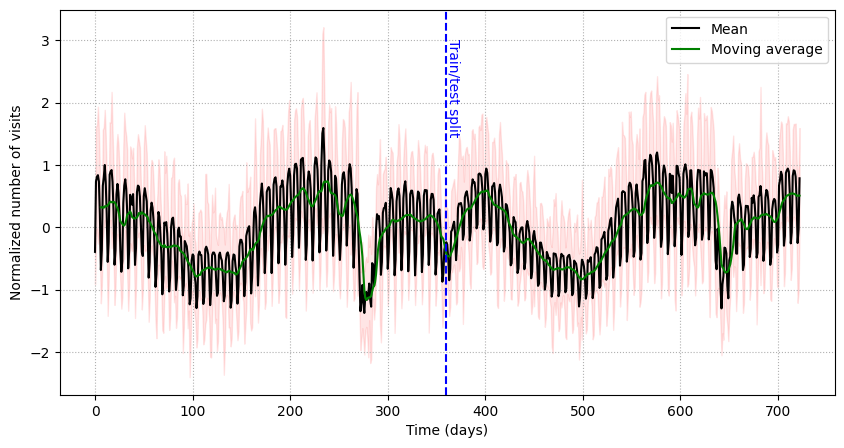

In [40]:
# Visualizing the data
mean_cases = [snapshot.y.mean().item() for snapshot in dataset]
std_cases = [snapshot.y.std().item() for snapshot in dataset]
df = pd.DataFrame(mean_cases, columns=['mean'])
df['std'] = pd.DataFrame(std_cases, columns=['std'])
df['rolling'] = df['mean'].rolling(7).mean()
                         
plt.figure(figsize=(10,5))
plt.plot(df['mean'], 'k-', label='Mean')
plt.plot(df['rolling'], 'g-', label='Moving average')
plt.grid(linestyle=':')
plt.fill_between(df.index, df['mean']-df['std'], df['mean']+df['std'], color='r', alpha=0.1)
plt.axvline(x=360, color='b', linestyle='--')
plt.text(360, 1.5, 'Train/test split', rotation=-90, color='b')
plt.xlabel('Time (days)')
plt.ylabel('Normalized number of visits')
plt.legend(loc='upper right')

In [41]:
import torch
torch.manual_seed(0)

class TemporalGNN(torch.nn.Module):
    def __init__(self, node_count, dim_in):
        super().__init__()
        self.recurrent = EvolveGCNH(node_count, dim_in)
        self.linear = torch.nn.Linear(dim_in, 1)

    def forward(self, x, edge_index, edge_weight):
        h = self.recurrent(x, edge_index, edge_weight).relu()
        h = self.linear(h)
        return h

In [42]:
model = TemporalGNN(dataset[0].x.shape[0], dataset[0].x.shape[1])
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
model.train()

# Training
for epoch in tqdm(range(50)):
    for i, snapshot in enumerate(train_dataset):
        y_pred = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
        loss = torch.mean((y_pred-snapshot.y)**2)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

100%|██████████| 50/50 [00:53<00:00,  1.07s/it]


In [43]:
# Evaluation
model.eval()
loss = 0
for i, snapshot in enumerate(test_dataset):
    y_pred = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
    mse = torch.mean((y_pred-snapshot.y)**2)
    loss += mse
loss = loss / (i+1)
print(f'MSE = {loss.item():.4f}')

MSE = 0.7462


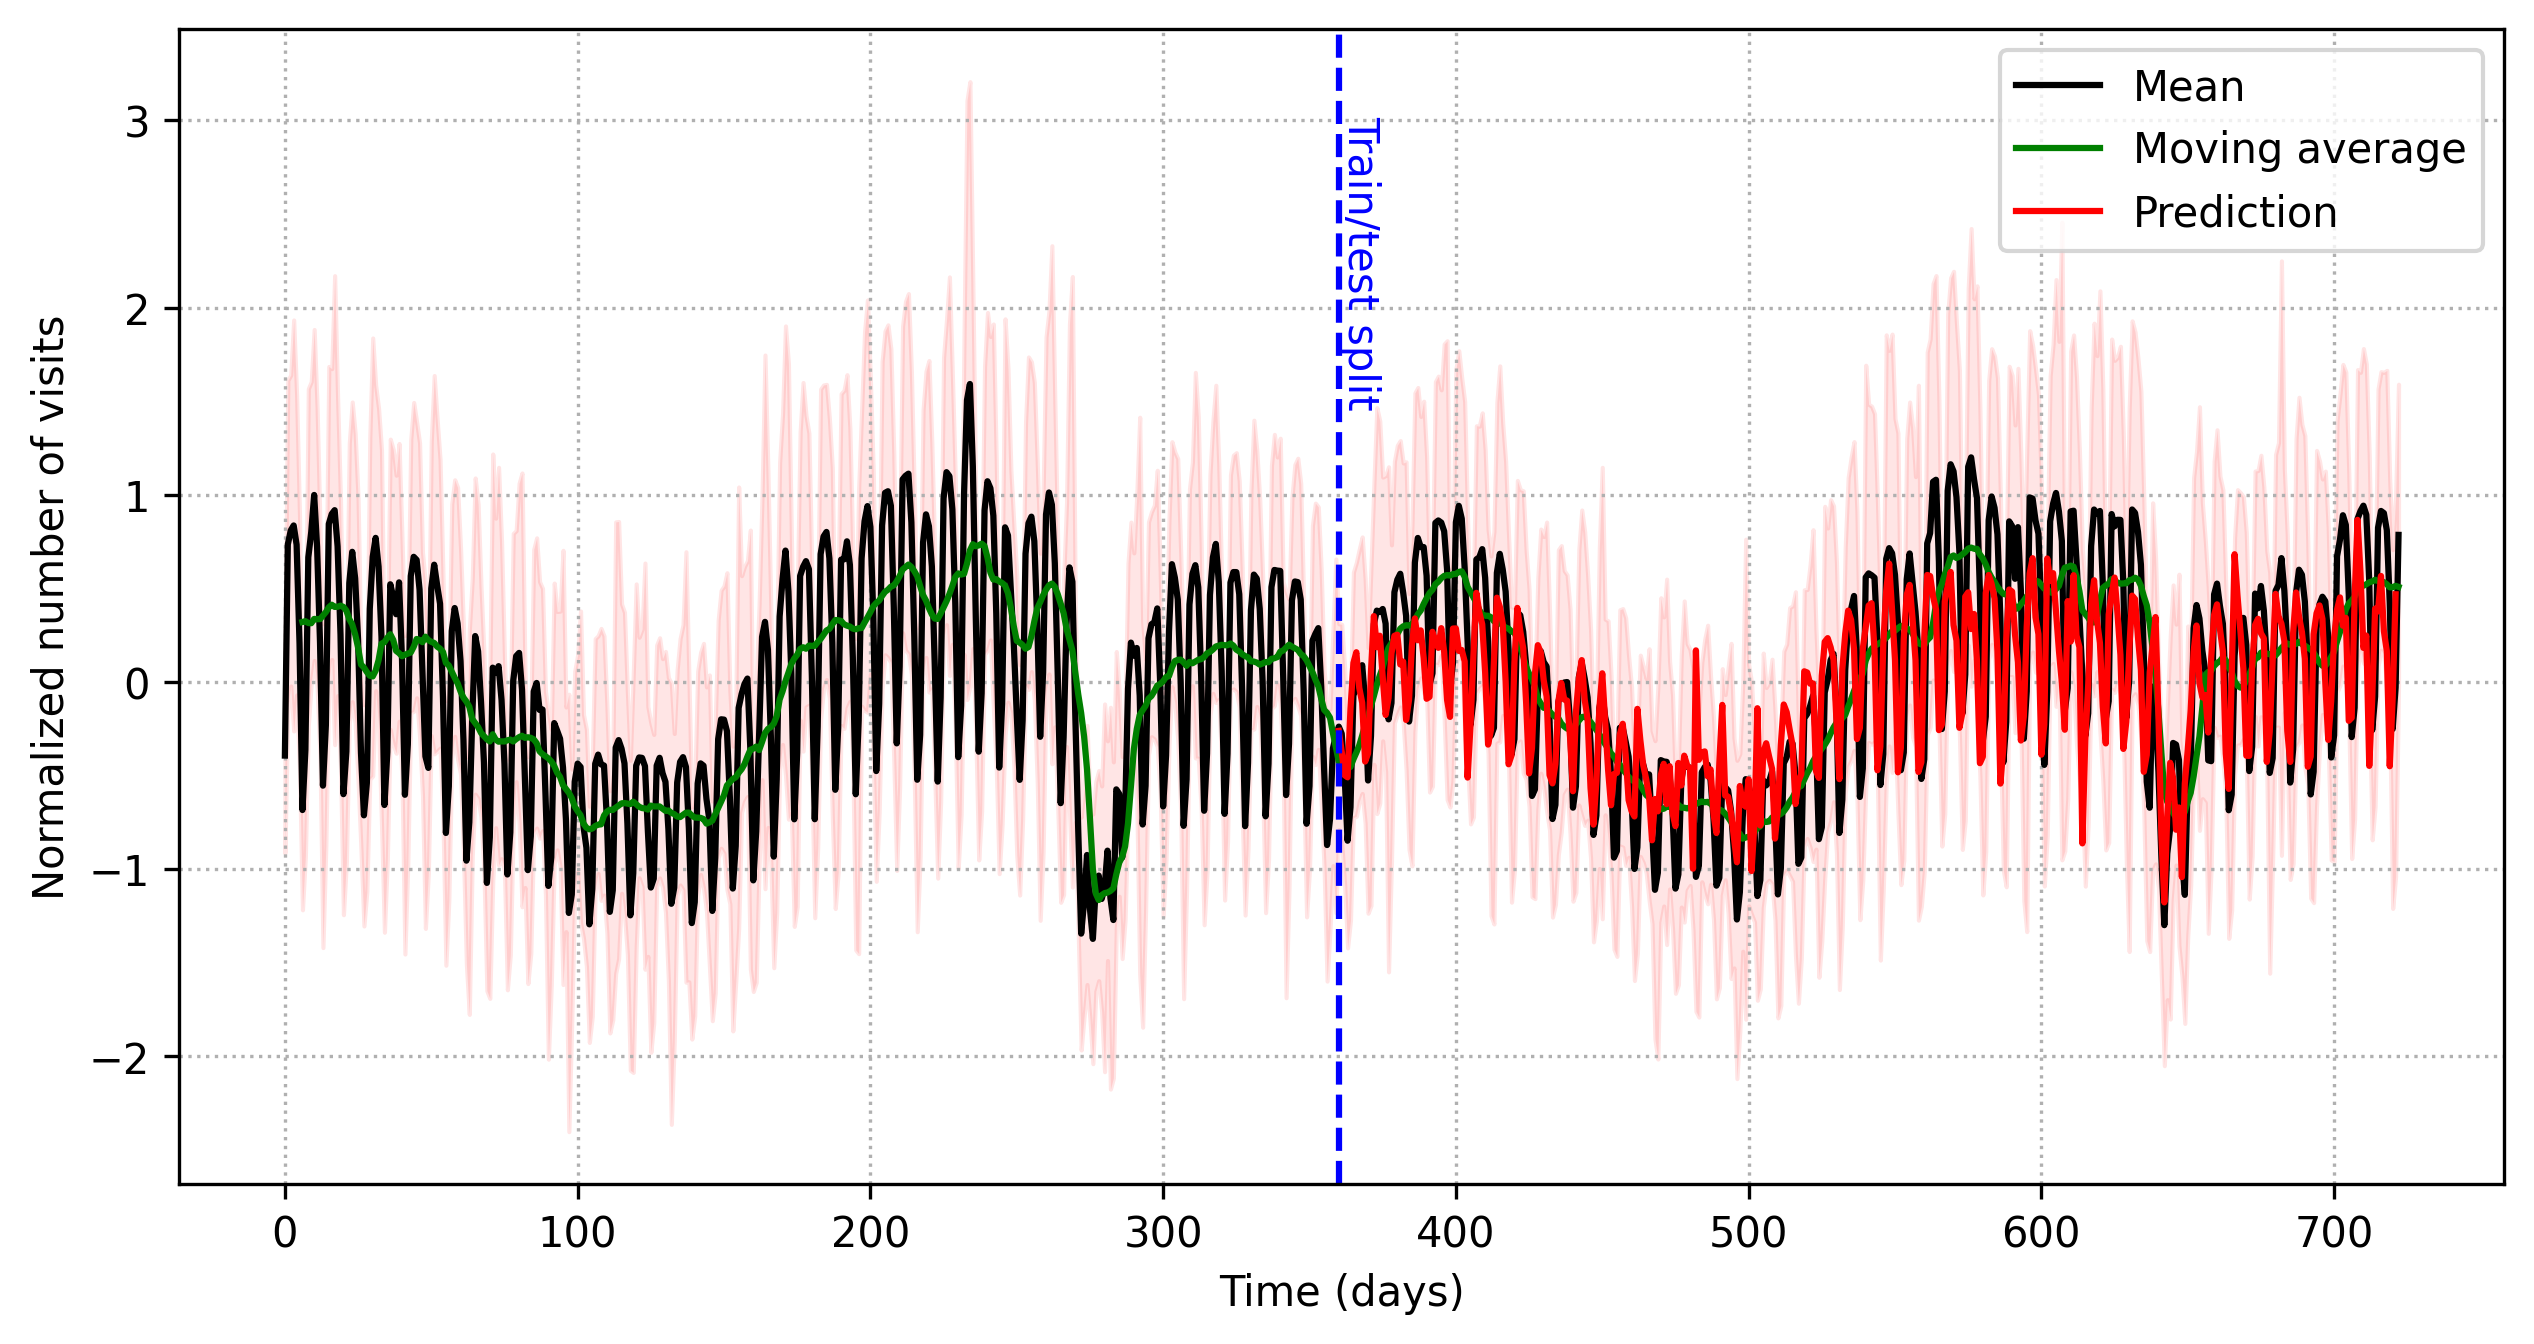

In [44]:
# Visualizing the predictions against real values
y_preds = [model(snapshot.x, snapshot.edge_index, snapshot.edge_attr).squeeze().detach().numpy().mean() for snapshot in test_dataset]

plt.figure(figsize=(10,5), dpi=300)
plt.plot(df['mean'], 'k-', label='Mean')
plt.plot(df['rolling'], 'g-', label='Moving average')
plt.plot(range(360,722), y_preds, 'r-', label='Prediction')
plt.grid(linestyle=':')
plt.fill_between(df.index, df['mean']-df['std'], df['mean']+df['std'], color='r', alpha=0.1)
plt.axvline(x=360, color='b', linestyle='--')
plt.text(360, 1.5, 'Train/test split', rotation=-90, color='b')
plt.xlabel('Time (days)')
plt.ylabel('Normalized number of visits')
plt.legend(loc='upper right')

<Axes: >

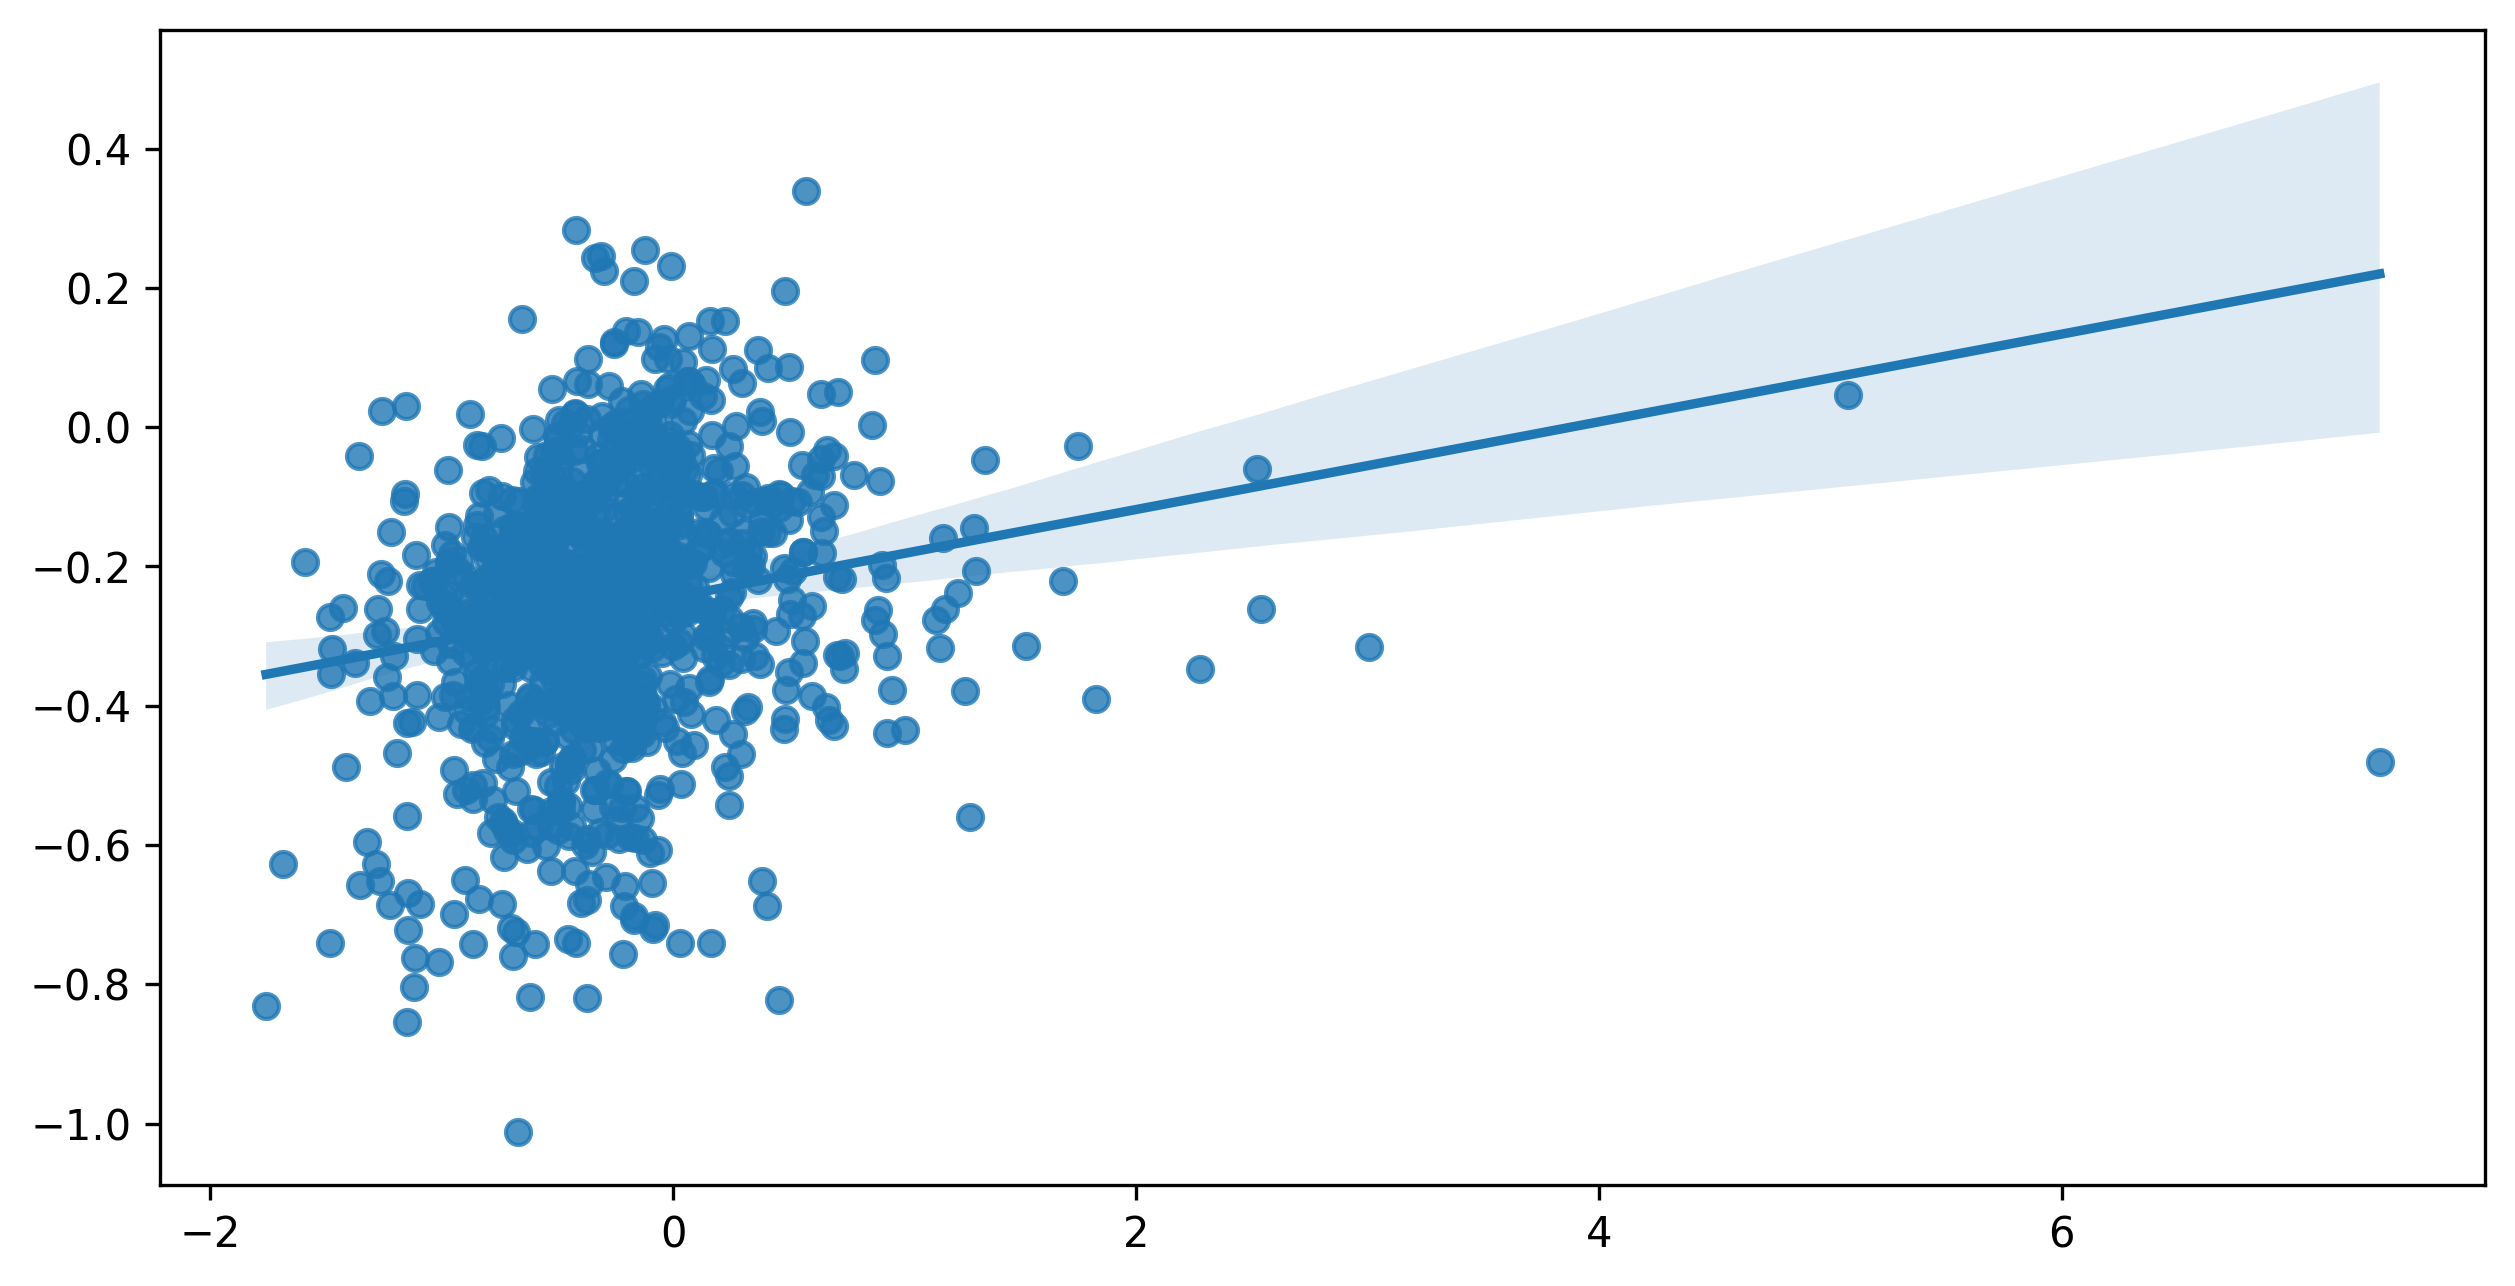

In [45]:
import seaborn as sns

y_pred = model(test_dataset[0].x, test_dataset[0].edge_index, test_dataset[0].edge_attr).detach().squeeze().numpy()

plt.figure(figsize=(10,5), dpi=300)
sns.regplot(x=test_dataset[0].y.numpy(), y=y_pred)

In [46]:
# Similarly creating a EvolveGCNO model
from torch_geometric_temporal.nn.recurrent import EvolveGCNO

class TemporalGNN(torch.nn.Module):
    def __init__(self, dim_in):
        super().__init__()
        self.recurrent = EvolveGCNO(dim_in, 1)
        self.linear = torch.nn.Linear(dim_in, 1)

    def forward(self, x, edge_index, edge_weight):
        h = self.recurrent(x, edge_index, edge_weight).relu()
        h = self.linear(h)
        return h

model = TemporalGNN(dataset[0].x.shape[1])

Predicting cases of COVID-19

Text(0, 0.5, 'Mean normalized number of cases')

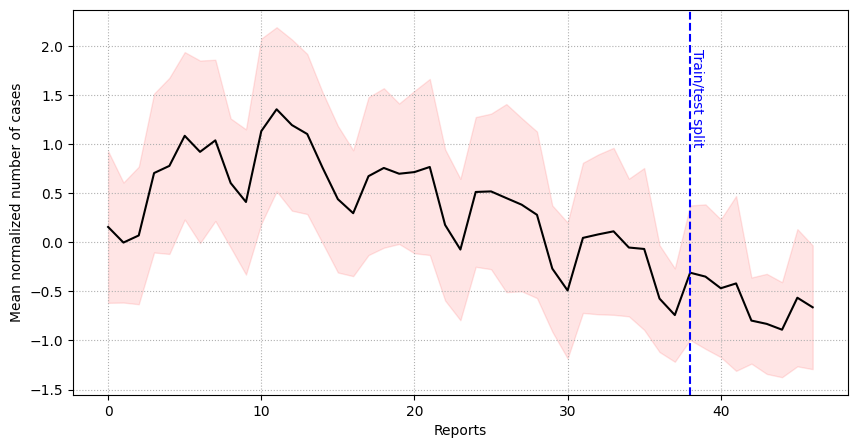

In [47]:
import pandas as pd
import matplotlib.pyplot as plt
from torch_geometric_temporal.dataset import EnglandCovidDatasetLoader
from torch_geometric_temporal.signal import temporal_signal_split

dataset = EnglandCovidDatasetLoader().get_dataset(lags=14)
train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.8)

mean_cases = [snapshot.y.mean().item() for snapshot in dataset]
std_cases = [snapshot.y.std().item() for snapshot in dataset]
df = pd.DataFrame(mean_cases, columns=['mean'])
df['std'] = pd.DataFrame(std_cases, columns=['std'])
                         
plt.figure(figsize=(10,5))
plt.plot(df['mean'], 'k-')
plt.grid(linestyle=':')
plt.fill_between(df.index, df['mean']-df['std'], df['mean']+df['std'], color='r', alpha=0.1)
plt.axvline(x=38, color='b', linestyle='--', label='Train/test split')
plt.text(38, 1, 'Train/test split', rotation=-90, color='b')
plt.xlabel('Reports')
plt.ylabel('Mean normalized number of cases')

In [48]:
from torch_geometric_temporal.nn.recurrent import MPNNLSTM

class TemporalGNN(torch.nn.Module):
    def __init__(self, dim_in, dim_h, num_nodes):
        super().__init__()
        self.recurrent = MPNNLSTM(dim_in, dim_h, num_nodes, 1, 0.5)
        self.dropout = torch.nn.Dropout(0.5)
        self.linear = torch.nn.Linear(2*dim_h + dim_in, 1)

    def forward(self, x, edge_index, edge_weight):
        h = self.recurrent(x, edge_index, edge_weight).relu()
        h = self.dropout(h)
        h = self.linear(h).tanh()
        return h

In [49]:
model = TemporalGNN(dataset[0].x.shape[1], 64, dataset[0].x.shape[0])
print(model)

TemporalGNN(
  (recurrent): MPNNLSTM(
    (_convolution_1): GCNConv(14, 64)
    (_convolution_2): GCNConv(64, 64)
    (_batch_norm_1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (_batch_norm_2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (_recurrent_1): LSTM(128, 64)
    (_recurrent_2): LSTM(64, 64)
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (linear): Linear(in_features=142, out_features=1, bias=True)
)


In [50]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model.train()

# Training
for epoch in tqdm(range(100)):
    loss = 0
    for i, snapshot in enumerate(train_dataset):
        y_pred = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
        loss = loss + torch.mean((y_pred-snapshot.y)**2)
    loss = loss / (i+1)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

100%|██████████| 100/100 [00:07<00:00, 13.31it/s]


In [51]:
# Evaluation
model.eval()
loss = 0
for i, snapshot in enumerate(test_dataset):
    y_pred = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
    mse = torch.mean((y_pred-snapshot.y)**2)
    loss += mse
loss = loss / (i+1)
print(f'MSE: {loss.item():.4f}')

MSE: 1.5052


Text(0, 0.5, 'Mean normalized number of cases')

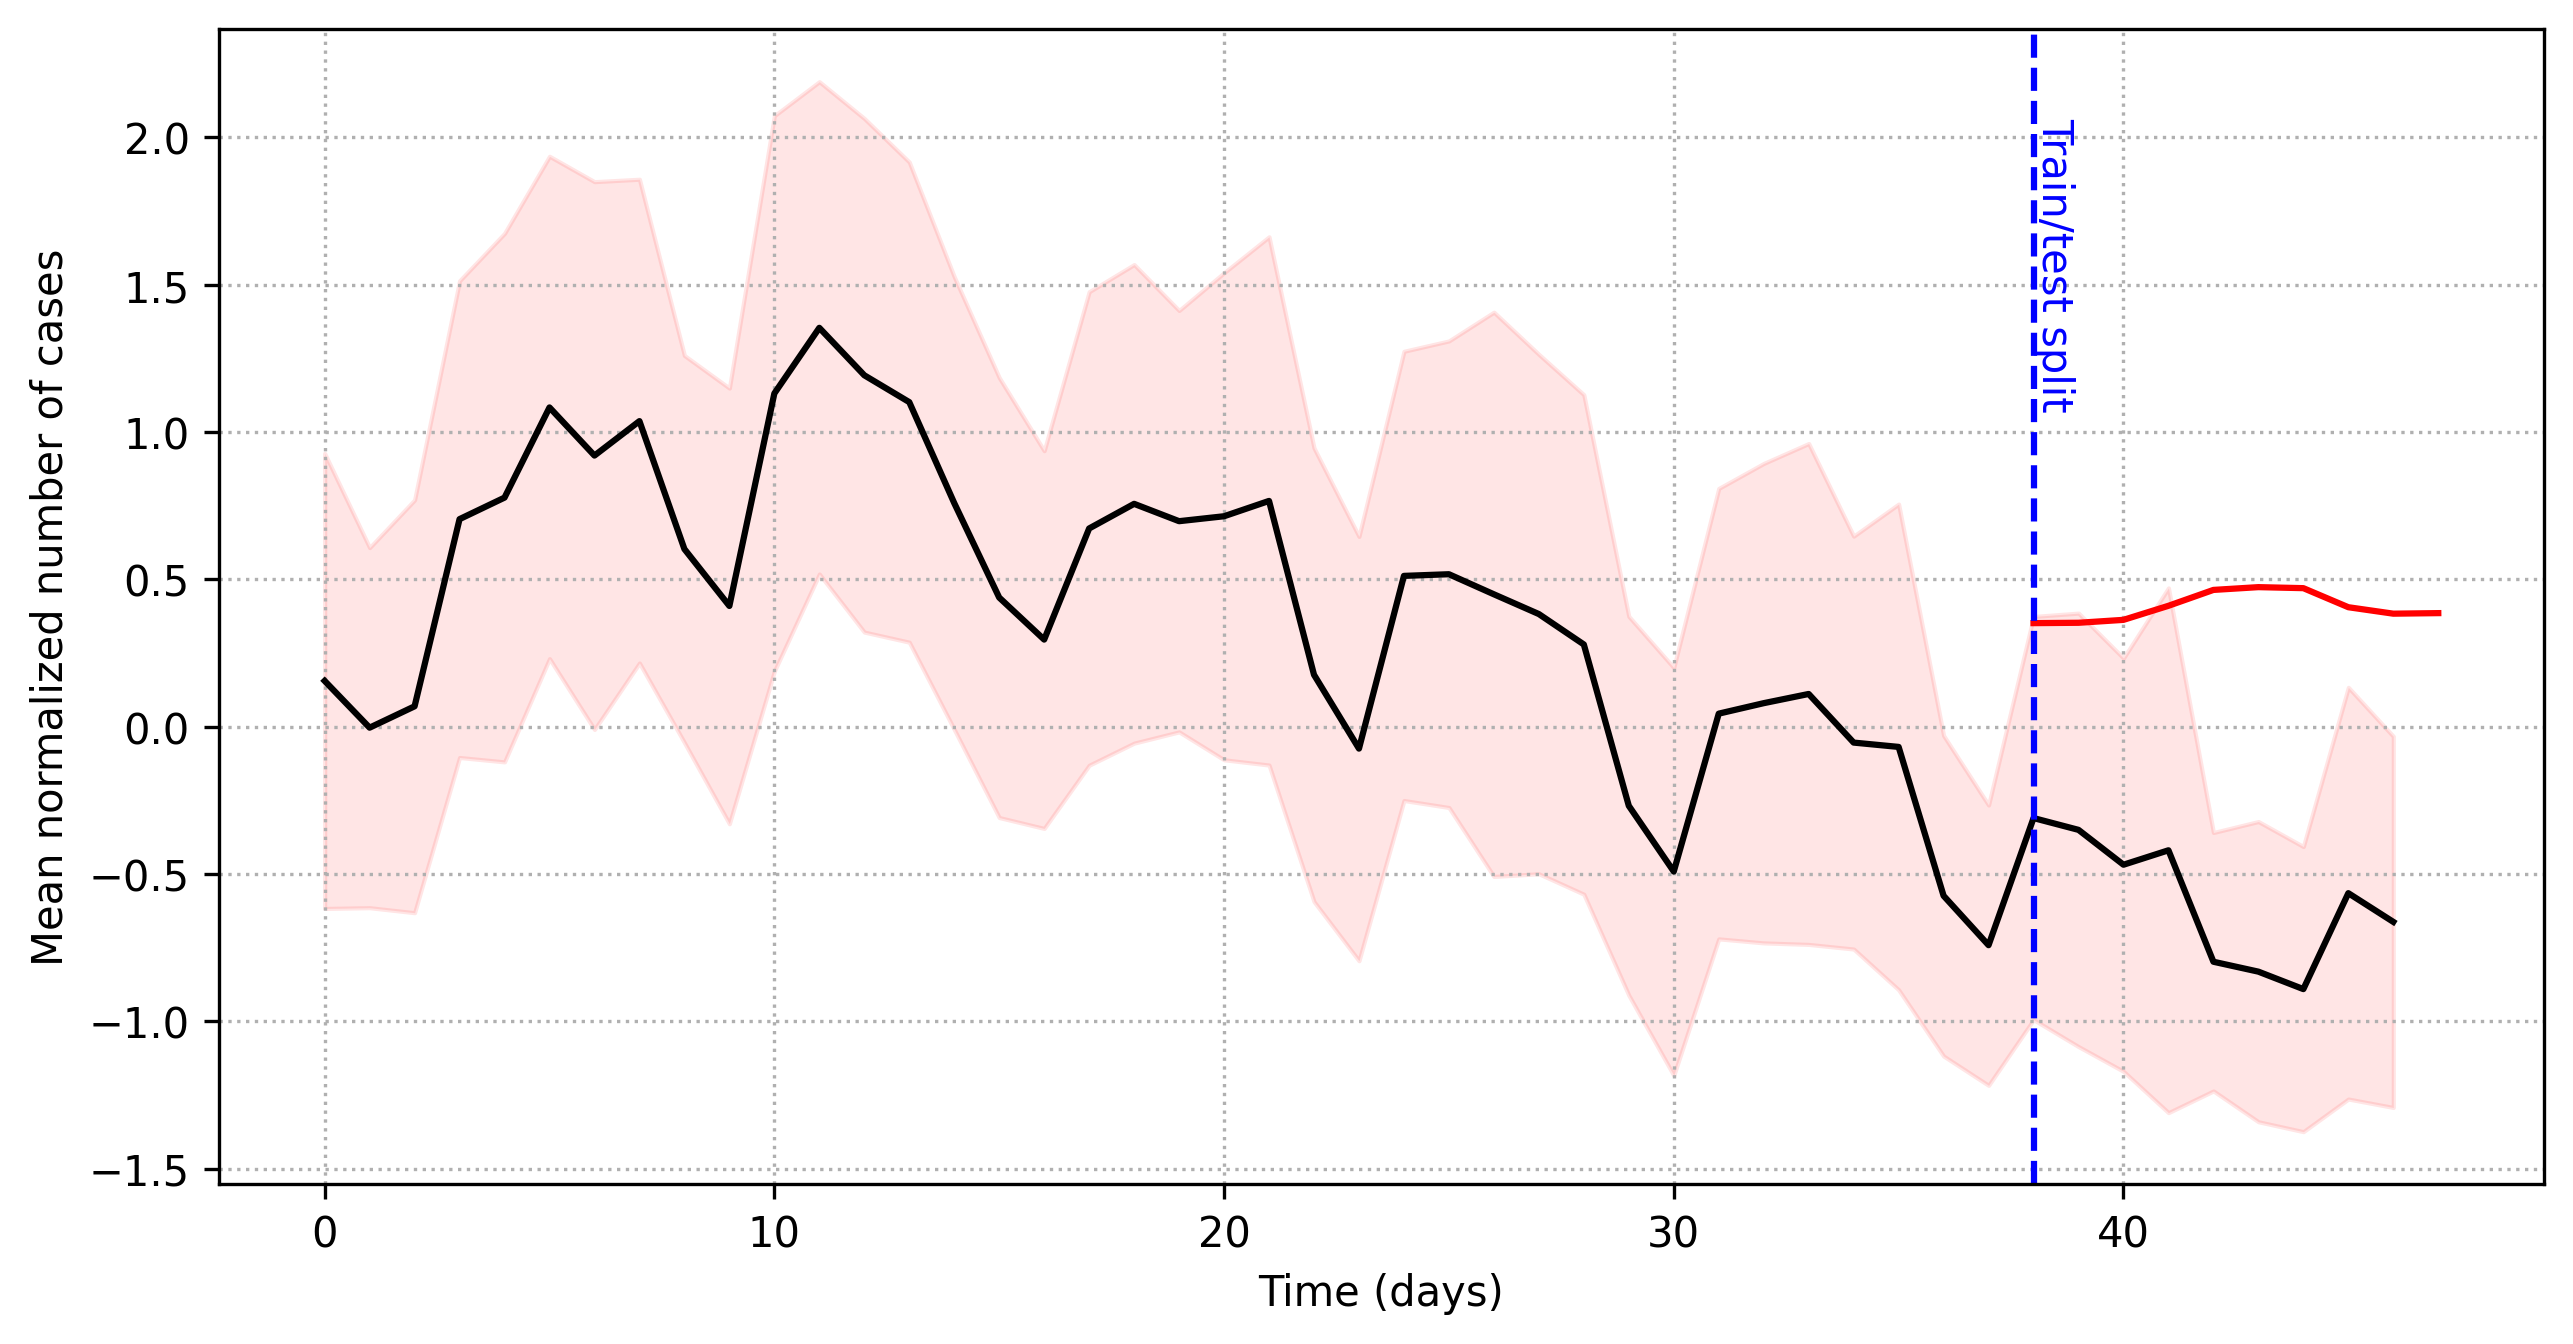

In [52]:
y_preds = [model(snapshot.x, snapshot.edge_index, snapshot.edge_attr).squeeze().detach().numpy().mean() for snapshot in test_dataset]

plt.figure(figsize=(10,5), dpi=300)
plt.plot(df['mean'], 'k-')
plt.plot(range(38,48), y_preds, 'r-', label='Prediction')
plt.grid(linestyle=':')
plt.fill_between(df.index, df['mean']-df['std'], df['mean']+df['std'], color='r', alpha=0.1)
plt.axvline(x=38, color='b', linestyle='--', label='Train/test split')
plt.text(38, 1.1, 'Train/test split', rotation=-90, color='b')
plt.xlabel('Time (days)')
plt.ylabel('Mean normalized number of cases')

<Axes: >

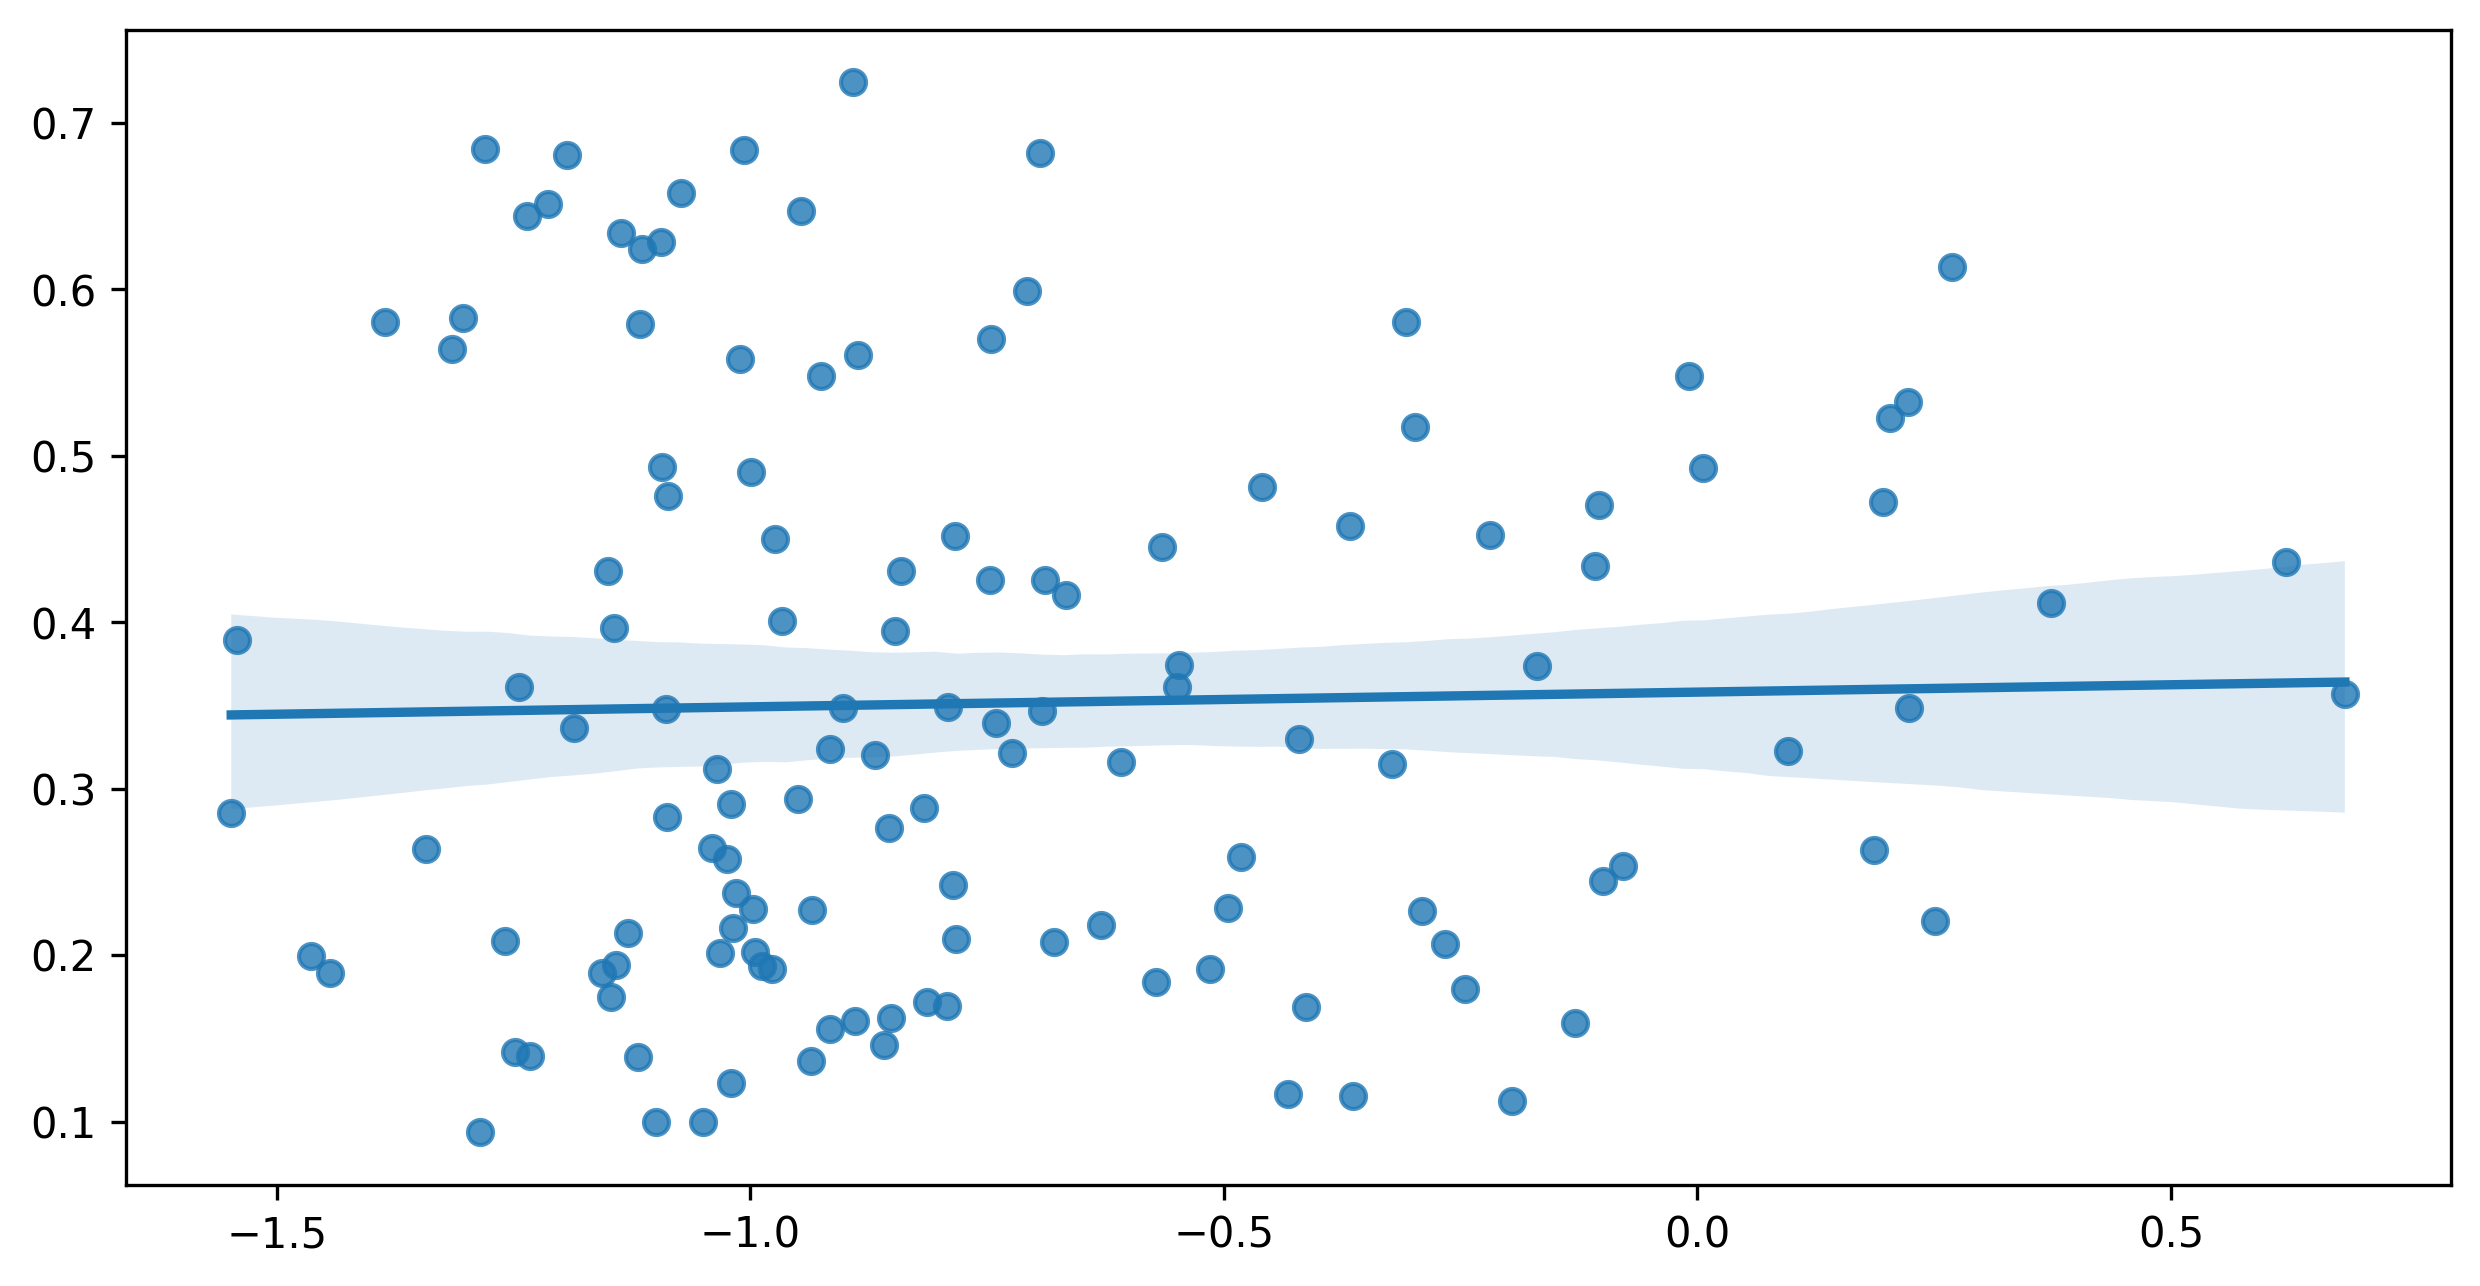

In [53]:
import seaborn as sns

y_pred = model(test_dataset[0].x, test_dataset[0].edge_index, test_dataset[0].edge_attr).detach().squeeze().numpy()

plt.figure(figsize=(10,5), dpi=300)
sns.regplot(x=test_dataset[0].y.numpy(), y=y_pred)

# Chapter 14

GNNExplainer uses node and edge masks to determine the relevance of features in a prediction by a GNN. This can increase the explainability of GNNs. It uses sparsity and MI (mutual information) to decide on relevant features

In [62]:
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
from torch.nn import Linear, Sequential, BatchNorm1d, ReLU, Dropout

from torch_geometric.datasets import TUDataset
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GINConv, global_add_pool
from torch_geometric.explain import Explainer, GNNExplainer, ModelConfig

dataset = TUDataset(root='data/TUDataset', name='MUTAG').shuffle()

# Create training, validation, and test sets
train_dataset = dataset[:int(len(dataset)*0.8)]
val_dataset   = dataset[int(len(dataset)*0.8):int(len(dataset)*0.9)]
test_dataset  = dataset[int(len(dataset)*0.9):]

# Create mini-batches
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=True)

In [56]:
class GIN(torch.nn.Module):
    """GIN"""
    def __init__(self, dim_h):
        super(GIN, self).__init__()
        self.conv1 = GINConv(
            Sequential(Linear(dataset.num_node_features, dim_h),
                       BatchNorm1d(dim_h), ReLU(),
                       Linear(dim_h, dim_h), ReLU()))
        self.conv2 = GINConv(
            Sequential(Linear(dim_h, dim_h), BatchNorm1d(dim_h), ReLU(),
                       Linear(dim_h, dim_h), ReLU()))
        self.conv3 = GINConv(
            Sequential(Linear(dim_h, dim_h), BatchNorm1d(dim_h), ReLU(),
                       Linear(dim_h, dim_h), ReLU()))
        self.lin1 = Linear(dim_h*3, dim_h*3)
        self.lin2 = Linear(dim_h*3, dataset.num_classes)

    def forward(self, x, edge_index, batch):
        h1 = self.conv1(x, edge_index)
        h2 = self.conv2(h1, edge_index)
        h3 = self.conv3(h2, edge_index)

        h1 = global_add_pool(h1, batch)
        h2 = global_add_pool(h2, batch)
        h3 = global_add_pool(h3, batch)

        h = torch.cat((h1, h2, h3), dim=1)

        h = self.lin1(h)
        h = h.relu()
        h = F.dropout(h, p=0.5, training=self.training)
        h = self.lin2(h)
        
        return F.log_softmax(h, dim=1)

model = GIN(dim_h=32)

In [57]:
model

GIN(
  (conv1): GINConv(nn=Sequential(
    (0): Linear(in_features=7, out_features=32, bias=True)
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=32, out_features=32, bias=True)
    (4): ReLU()
  ))
  (conv2): GINConv(nn=Sequential(
    (0): Linear(in_features=32, out_features=32, bias=True)
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=32, out_features=32, bias=True)
    (4): ReLU()
  ))
  (conv3): GINConv(nn=Sequential(
    (0): Linear(in_features=32, out_features=32, bias=True)
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=32, out_features=32, bias=True)
    (4): ReLU()
  ))
  (lin1): Linear(in_features=96, out_features=96, bias=True)
  (lin2): Linear(in_features=96, out_features=2, bias=True)
)

In [58]:
@torch.no_grad()
def test(model, loader):
    criterion = torch.nn.CrossEntropyLoss()
    model.eval()
    loss = 0
    acc = 0

    for data in loader:
        out = model(data.x, data.edge_index, data.batch)
        loss += criterion(out, data.y) / len(loader)
        acc += accuracy(out.argmax(dim=1), data.y) / len(loader)

    return loss, acc

def accuracy(pred_y, y):
    return ((pred_y == y).sum() / len(y)).item()

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
epochs = 200

model.train()
for epoch in range(epochs+1):
    total_loss = 0
    acc = 0
    val_loss = 0
    val_acc = 0

    # Train on batches
    for data in train_loader:
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.batch)
        loss = criterion(out, data.y)
        total_loss += loss / len(train_loader)
        acc += accuracy(out.argmax(dim=1), data.y) / len(train_loader)
        loss.backward()
        optimizer.step()

        # Validation
        val_loss, val_acc = test(model, val_loader)

    # Print metrics every 20 epochs
    if(epoch % 20 == 0):
        print(f'Epoch {epoch:>3} | Train Loss: {total_loss:.2f} | Train Acc: {acc*100:>5.2f}% | Val Loss: {val_loss:.2f} | Val Acc: {val_acc*100:.2f}%')

test_loss, test_acc = test(model, test_loader)
print(f'Test Loss: {test_loss:.2f} | Test Acc: {test_acc*100:.2f}%')

Epoch   0 | Train Loss: 0.83 | Train Acc: 66.38% | Val Loss: 0.66 | Val Acc: 78.95%
Epoch  20 | Train Loss: 0.44 | Train Acc: 78.31% | Val Loss: 0.47 | Val Acc: 84.21%
Epoch  40 | Train Loss: 0.37 | Train Acc: 78.84% | Val Loss: 0.31 | Val Acc: 89.47%
Epoch  60 | Train Loss: 0.34 | Train Acc: 89.20% | Val Loss: 0.29 | Val Acc: 89.47%
Epoch  80 | Train Loss: 0.21 | Train Acc: 91.76% | Val Loss: 0.17 | Val Acc: 89.47%
Epoch 100 | Train Loss: 0.25 | Train Acc: 87.22% | Val Loss: 0.38 | Val Acc: 89.47%
Epoch 120 | Train Loss: 0.20 | Train Acc: 89.73% | Val Loss: 0.47 | Val Acc: 89.47%
Epoch 140 | Train Loss: 0.16 | Train Acc: 92.76% | Val Loss: 0.23 | Val Acc: 89.47%
Epoch 160 | Train Loss: 0.21 | Train Acc: 91.71% | Val Loss: 0.41 | Val Acc: 89.47%
Epoch 180 | Train Loss: 0.15 | Train Acc: 92.23% | Val Loss: 0.10 | Val Acc: 94.74%
Epoch 200 | Train Loss: 0.21 | Train Acc: 89.58% | Val Loss: 0.18 | Val Acc: 89.47%
Test Loss: 0.47 | Test Acc: 78.95%


In [68]:
explainer_pyg = Explainer(
    model=model,
    algorithm=GNNExplainer(epochs=200),
    explanation_type='model',
    node_mask_type='attributes',
    edge_mask_type='object',
    model_config=dict(
        mode='binary_classification',
        task_level='node',
        return_type='raw',
    ),
)

for data in tqdm(train_loader):
    explanation_pyg = explainer_pyg(
    x=data.x,
    edge_index=data.edge_index,
    batch=data.batch,
    target=data.y
)

  0%|          | 0/3 [00:00<?, ?it/s]/Users/ishaanpaul/Desktop/Extras/Graph-Neural-Network/.venv/lib/python3.12/site-packages/torch_geometric/explain/explainer.py:193: UserWarning: The 'target' should not be provided for the explanation type 'model'
  warnings.warn(
100%|██████████| 3/3 [00:01<00:00,  2.91it/s]


In [69]:
model.eval()

# The index of the graph in the dataset you want to explain
graph_index = 165

# Get the specific graph data
data = dataset[graph_index]

# Generate the explanation for the graph
explanation_pyg = explainer_pyg(
    x=data.x,
    edge_index=data.edge_index,
    batch=data.batch,
    target=data.y
)

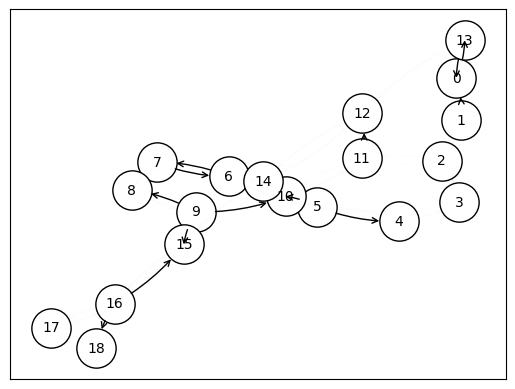

In [73]:
explanation_pyg.visualize_graph()

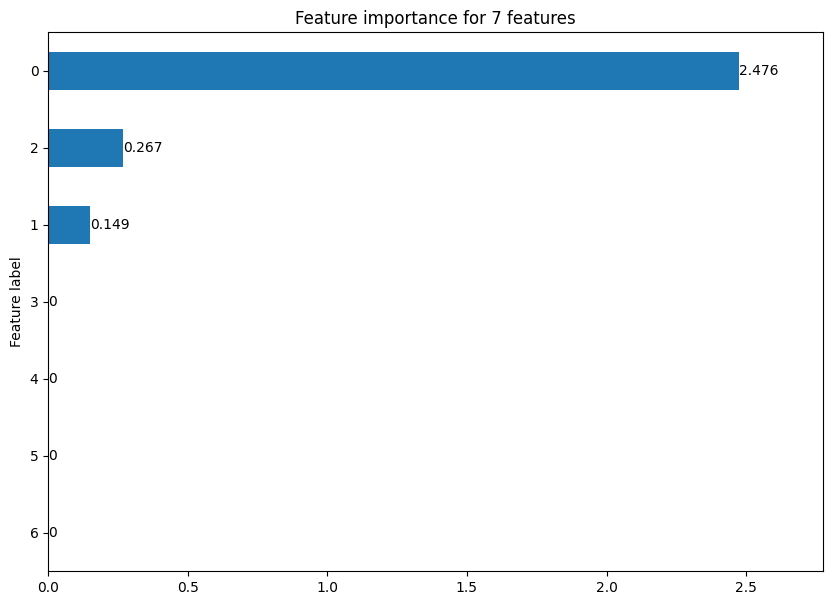

In [77]:
explanation_pyg.visualize_feature_importance()

Explaining GNNs with Captum

In [82]:
import numpy as np
np.random.seed(0)
import tqdm
import matplotlib.pyplot as plt
import torch.nn.functional as F
from captum.attr import IntegratedGradients

import torch_geometric.transforms as T
from torch_geometric.datasets import Twitch
from torch_geometric.nn import to_captum_model, to_captum_input
from torch_geometric.explain import Explainer


dataset = Twitch('.', name="EN")
data = dataset[0]
data

Data(x=[7126, 128], edge_index=[2, 77774], y=[7126])

In [89]:
print(data.x.shape)
print(data.edge_index.shape)


torch.Size([7126, 128])
torch.Size([2, 77774])


In [ ]:
class GCN(torch.nn.Module):
    def __init__(self, dim_h):
        super().__init__()
        self.conv1 = GCNConv(dataset.num_features, dim_h)
        self.conv2 = GCNConv(dim_h, dataset.num_classes)

    def forward(self, x, edge_index):
        h = self.conv1(x, edge_index).relu()
        h = F.dropout(h, p=0.5, training=self.training)
        h = self.conv2(h, edge_index)
        return F.log_softmax(h, dim=1)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN(64).to(device)
data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)

for epoch in range(200):
    model.train()
    optimizer.zero_grad()
    log_logits = model(data.x, data.edge_index)    
    loss = F.nll_loss(log_logits, data.y)
    loss.backward()
    optimizer.step()

def accuracy(pred_y, y):
    return ((pred_y == y).sum() / len(y)).item()

@torch.no_grad()
def test(model, data):
    model.eval()
    out = model(data.x, data.edge_index)
    acc = accuracy(out.argmax(dim=1), data.y)
    return acc
  
acc = test(model, data)
print(f'Accuracy: {acc*100:.2f}%')